In [1]:
import os
os.chdir('/home/amb2022/clusterCCA_revision1/clusterCCA')
from pcmf import path_plot, plot_cluster_assignments, two_cluster_data, pcmf_full
from p3ca import cluster_metrics, calculate_scores_nonpath
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import normalized_mutual_info_score
from scipy.stats import multivariate_normal
from collections import OrderedDict

import time
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment as linear_assignment
import seaborn as sns; sns.set()
import numpy as np
os.chdir('/home/amb2022/clusterCCA_revision1/clusterCCA/utils/subspace-clustering-master/')
from cluster.selfrepresentation import ElasticNetSubspaceClustering


os.chdir('/home/amb2022/clusterCCA_revision1/clusterCCA')
from pcmf import sparse_D, get_weights
from pcmf import cluster_path, select_fit, cluster_fit



In [2]:

def centroid_matrix(X,labels):
    '''
    Given a matrix X and labels clustering each of it's rows, return a matrix 
    where each row has been replaced by it's nearest centroid.
    '''
    centroid_dict = dict()
    X_out = np.zeros_like(X)
    keys, counts = np.unique(labels, return_counts=True)
    for k in keys:
        centroid_dict[k] = list() # np.zeros(X.shape[1])
    for i,l in enumerate(labels):
        centroid_dict[l].append(X[i,:])
    for j,k in enumerate(keys):
        centroid_dict[k] = np.mean(np.asarray(centroid_dict[k]), axis=0)
    for i,l in enumerate(labels):
        X_out[i,:] = centroid_dict[l]
    return X_out

def centroid_matrix_mixture(X,proba,means):
    '''
    Given a matrix X and labels clustering each of it's rows, return a matrix 
    where each row has been replaced by it's nearest centroid.
    '''
    centroid_dict = dict()
    X_out = np.zeros_like(X)
    for i in range(X_out.shape[0]):
        X_out[i,:] = np.dot(proba[i],means)
    return X_out

########### Model Selection functions ############
def cluster_fit(Xhat, num_clusters=2, gamma=2.0,  method='spectral'):
    # Cluster on the rows of Xhat with k=n_clust_previous
    if method == 'spectral':
        # clustering = SpectralClustering(n_clusters = num_clusters, gamma=gamma, \
                                        # assign_labels='discretize',affinity='rbf')
        clustering = SpectralClustering(n_clusters=num_clusters, random_state=0, gamma=gamma).fit(Xhat)
    elif method == 'kmeans':
        clustering = KMeans(n_clusters=num_clusters, random_state=0)
    elif method == 'gmm':
        clustering = GaussianMixture(n_components=num_clusters, warm_start=True)
    else:
        return ValueError('Selected clustering method not yet implemented.')
    clustering.fit(Xhat)
    #
    return clustering.labels_

def select_fit(n_clusts, ics, num_clusters):
    start_num = np.where(np.array(n_clusts)==num_clusters)[0]
    if len(start_num) > 1:
        start_num = start_num[0]
    vals = np.array(ics)[np.where(np.array(n_clusts)==num_clusters)]
    idxs = np.where(vals == np.min(vals))[0]
    if len(idxs) > 1:
        idxs = idxs[0]
    return start_num + idxs

def cluster_path(X_c, Xhat_list, penalty_list, gauss_coef, neighbors, verbose=False):
    '''
    Estimate number of clusters and fit quality at each value of the penalty.
    '''
    ics = []
    n_clusts = []
    centroids = []
    n_clust = 1
    D = sparse_D(X_c.shape[0],X_c.shape[1])
    weights = get_weights(X_c, gauss_coef=gauss_coef, neighbors=neighbors)
    #
    notinf_idx = np.where(np.asarray(penalty_list)<np.inf)[0]
    penalty_list = penalty_list[notinf_idx]
    Xhat_list = [Xhat_list[i] for i in range(len(Xhat_list)) if i in notinf_idx]
    for i,Xhat in enumerate(Xhat_list):
        penalty = penalty_list[i]
        if n_clust < Xhat.shape[0]:
            out, n_clust, labels, ic = cluster_forwardstep(Xhat, X_c, D, n_clust, penalty, weights, 
                                                            method='spectral', gamma=gauss_coef, selection='lik', verbose=verbose)
        n_clusts.append(n_clust)
        ics.append(ic)
        centroids.append(out)
    return n_clusts, ics, centroids

from p3ca import convex_clust_df
def cluster_forwardstep(Xhat, X, D, n_clust_previous, penalty, weights, method='spectral', gamma=1.0, selection='bic', verbose=False):
    epsilon = penalty
    #
    # Cluster on the rows of Xhat with k=n_clust_previous
    if method == 'spectral':
        clustering = SpectralClustering(n_clusters = n_clust_previous, gamma=gamma, \
                                        assign_labels='discretize',affinity='rbf')
    elif method == 'kmeans':
        clustering = KMeans(n_clusters=n_clust_previous, random_state=0)
    elif method == 'gmm':
        clustering = GaussianMixture(n_components=n_clust_previous, warm_start=True)
    else:
        return ValueError('Selected clustering method not yet implemented.')
    clustering.fit(Xhat)
    #
    labels1 = clustering.labels_
    Xhat1 = centroid_matrix(Xhat, labels1)
    df1 = n_clust_previous + 2
    #df1 = convex_clust_df(Xhat1, penalty, epsilon = epsilon)  
    if np.isnan(df1):
        df1 = 1
    #print('DF1:',df1, n_clust_previous)
    #
    # Cluster on the rows of V with k=n_clust_previous+1 
    if method == 'spectral':
        clustering = SpectralClustering(n_clusters = n_clust_previous+1, gamma=gamma, \
                                        assign_labels='discretize',affinity='rbf')
    elif method == 'kmeans':
        clustering = KMeans(n_clusters=n_clust_previous+1, random_state=0)
    elif method == 'gmm':
        clustering = GaussianMixture(n_components=n_clust_previous+1, warm_start=True)
    else:
        return ValueError('Selected clustering method not yet implemented.')
    clustering.fit(Xhat)
    #
    labels2 = clustering.labels_
    Xhat2 = centroid_matrix(Xhat, labels2)
    df2 = n_clust_previous + 1 + 2
    #df2 = convex_clust_df(Xhat2, penalty, epsilon = epsilon)      
    if np.isnan(df2):
        df2 = 2
    #print('DF2:',df2,n_clust_previous+1)
    #
    # Check loss for both clusterings
    loglik1 = np.linalg.norm(X - Xhat1, 2)**2 + penalty*np.sum(weights*np.sum(np.abs(D*Xhat1),axis=1))
    loglik2 = np.linalg.norm(X - Xhat2, 2)**2 + penalty*np.sum(weights*np.sum(np.abs(D*Xhat2),axis=1))
    #
    if selection == 'aic':
        ic1 = loglik1 + 2*df1 
        ic2 = loglik2 + 2*df2 
    elif selection == 'bic':
        ic1 = loglik1 + df1*np.log(Xhat.shape[0])
        ic2 = loglik2 + df2*np.log(Xhat.shape[0])
    else:
        ic1 = loglik1
        ic2 = loglik2
    #
    if verbose:
        print("IC1, IC2, Penalty, Penalty Term:",ic1,ic2,penalty,np.sum(weights*np.sum(np.abs(D*Xhat2),axis=1)))
    if np.isnan(ic1):
        ic1 = np.inf
    #
    # Return the better clustering 
    if ic1 >= ic2:
        if verbose:
            print('Num clusters:', n_clust_previous+1)
        return centroid_matrix(Xhat,labels2), n_clust_previous+1, labels2, ic2
    else:
        if verbose:
            print('Num clusters:', n_clust_previous)
        return centroid_matrix(Xhat,labels1), n_clust_previous, labels1, ic1

def convex_clust_df(uV, penalty, epsilon = 0.75):
    D = sparse_D(uV.shape[0], uV.shape[1])
    zero_idxs = np.where(np.sum(np.abs(D*uV),axis=1) <= epsilon)[0]

    D0 = D[zero_idxs,:]
    D1 = D[[i for i in range(D.shape[0]) if i not in zero_idxs],:]

    chol_D0 = cholesky_AAt(D0, beta=1.0)
    I = np.eye(D.shape[1])
    P = I - D0.T * chol_D0(D0)

    LHS = (1.0/np.linalg.norm(D1*uV)) * (D1.T * D1)
    RHS = (1.0/np.linalg.norm(D1*uV)**3) * ((D1.T*D1)*np.dot(uV, uV.T)*(D1.T*D1))

    df_hat = np.trace(np.linalg.inv(I + penalty*P*(LHS - RHS)) * P)
    return df_hat

from pcmf import pcmf_full, pcmf_approx_uV, pcmf_full_consensus, save_multi_image, two_cluster_data, generate_cluster_PMD_data
def load_experiments(data_path, pcmf_type, data_type, r=7, m=5, n_clusters=20):
    results = np.load(data_path, allow_pickle=True)
    gauss_coef = float(results['gauss_coef'])
    neighbors = int(results['neighbors'])
    penalty_list = list(results['penalty_list'])
    if data_type == 'numerical':
        means = [-5.2, 5.2, -4.8, 4.8, -4.1, 4.1, -3.7, 3.7, -3.1, 3.1,-2.8, 2.8, -2.1, 2.1, -1.5, 1.5, -1.0, 1.0, -0.4, 0.4]
        sigma = results['sigma']
        seeds = results['seeds']
        scale_data = results['scale_data'] # True
        intercept = results['intercept']
        ms = [m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m]
        num_vars = results['n_X']
        density = results['density']
        X_clusters, u_true, v_true, _=generate_cluster_PMD_data(ms, num_vars, sigma, density, n_clusters, means=means) 
        X=np.vstack(X_clusters)
        np.random.seed(seed=1234)
        idx_perm=np.random.permutation(X.shape[0])
        X=X[idx_perm,:]
#         true_clusters = results['true_clusters']
        true_clusters=np.repeat([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],m)
        true_clusters=true_clusters[idx_perm]

    else:
        X = results['X_c']
        true_clusters = results['true_clusters']
     #
    # if dataset=='_SRBCT_genomics':
    #     idx_keep = ~np.isnan(true_clusters)
    #     true_clusters = true_clusters[idx_keep]
    if pcmf_type == 'pcmf_full':
        A = results['A']
        Xhat_list = A
    elif pcmf_type == 'pcmf_approx_uV':
        U = results['U']
        V = results['V']
        Xhat_list = []
        #
        for i in range(len(penalty_list)):
            Xhat_list.append(U[i] * V[i])
    elif pcmf_type == 'pcmf_full_consensus':
        A = results['A']
        Xhat_list = A
    else:
        print('Incorrect pcmf_type')
    #
    return X, Xhat_list, true_clusters, results, u_true, v_true

from sklearn.cluster import SpectralClustering
def confusion_matrix_ordered(pred, true):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))
    js = [e for e in sorted(indexes, key=lambda x: x[0])[1]]
    conf_mat_ord = conf_mat[:, js]
    return conf_mat_ord

def fit_pcmf(X, true_clusters, n_clusters, gauss_coef, c_method='spectral'):
    '''PCMF spectral clustering'''
    from sklearn.cluster import SpectralClustering
    #
    data_in = X
    #
    labels = cluster_fit(X, num_clusters=n_clusters, gamma=gauss_coef, method=c_method)
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def centroid_matrix(X,labels):
    '''
    Given a matrix X and labels clustering each of it's rows, return a matrix 
    where each row has been replaced by it's nearest centroid.
    '''
    centroid_dict = dict()
    X_out = np.zeros_like(X)
    keys, counts = np.unique(labels, return_counts=True)
    for k in keys:
        centroid_dict[k] = list() # np.zeros(X.shape[1])
    for i,l in enumerate(labels):
        centroid_dict[l].append(X[i,:])
    for j,k in enumerate(keys):
        centroid_dict[k] = np.mean(np.asarray(centroid_dict[k]), axis=0)
    for i,l in enumerate(labels):
        X_out[i,:] = centroid_dict[l]
    return X_out

def path_plot(coefficient_arr, penalty_list,plot_range=[0,-1], cut_vars=False, first_vars_only=False, var_sel=1):
    # Crop x axis (e.g, to remove 'burn-in' period at beginning)
    coefficient_arr = coefficient_arr[plot_range[0]:plot_range[1],:,:]
    penalty_list = penalty_list[plot_range[0]:plot_range[1]]
    if cut_vars is True:
        coefficient_arr = coefficient_arr[:,:,[1,2,coefficient_arr.shape[2]-1]]
        
    if first_vars_only is True:
        coefficient_arr = coefficient_arr[:,:,[var_sel]]

    # Colormap
    cmap = cm.get_cmap('viridis', coefficient_arr.shape[2])
    colors = cmap(np.linspace(0.0,1.0,coefficient_arr.shape[2]))

    # Define x-axis range
    penalty_range = range(len(penalty_list))

    fig, ax = plt.subplots(1,1, figsize=(20,10))
    for i in range(coefficient_arr.shape[2]):
        x = np.round(np.array(penalty_list),8)[penalty_range]
        y = coefficient_arr[penalty_range,:,i]
        ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.15)
        ax.set_xticks(range(x.shape[0]), minor=False);
        ax.set_facecolor('white')
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        ax.set_xticklabels(x,fontsize=24)
        evens = np.arange(0,len(ax.xaxis.get_ticklabels())+1,2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    ax.tick_params(axis='y', labelsize=24)
    plt.xlabel(r'$\lambda$',fontsize=24)
    plt.ylabel('Coefficients',fontsize=24)


In [3]:
os.chdir('/home/amb2022/clusterCCA_revision1/clusterCCA')
# data_path='results/pcmf_full_consensus_synthetic_run7_div_consensusComparison_20Classes_n1000_p1000_density0.5_gausscoef5.0_neighbors50_admm_iters20_rho1.0.npz'
# data_path='results/pcmf_full_synthetic_run7_div_consensusComparison_20Classes_n100_p1000_density0.5_gausscoef5.0_neighbors10_admm_iters20_rho1.0.npz'
# data_path='results/pcmf_full_synthetic_run7_div_consensusComparison_20Classes_p1000_density0.5_gausscoef5.0_neighbors15_admm_iters20_rho1.0.npz'
# data_path = 'results/pcmf_full_consensus_synthetic_run7_div_consensusComparison_20Classes_n1000_p1000_density0.5_split_size_100_gausscoef5.0_neighbors50_admm_iters20_rho1.0.npz'
data_path = 'results/pcmf_full_consensus_synthetic_run7_div_consensusComparison_20Classes_n1000_p100_density0.5_split_size_100_gausscoef5.0_neighbors50_admm_iters20_rho1.0.npz'
print(data_path)
X, Xhat_list, true_clusters, results, u_true, v_true = load_experiments(data_path, 'pcmf_full_consensus', 'numerical', r=7, m=50)
print(X.shape, Xhat_list.shape)
penalty_list=results['penalty_list']
os.chdir('experiments/icml-2022')
from path_fits import fit_spectral, fit_dpgmm

# fit_dpgmm(Xhat_list[40][:,0:2], true_clusters, 20)


results/pcmf_full_consensus_synthetic_run7_div_consensusComparison_20Classes_n1000_p100_density0.5_split_size_100_gausscoef5.0_neighbors50_admm_iters20_rho1.0.npz
(1000, 100) (60, 1000, 100)


In [6]:
results['V'].shape
X_c = np.hstack((X,np.ones((X.shape[0],1))))
print(X_c.shape)

# print(X_all.shape)
# penalty_list = np.concatenate((np.repeat(np.inf,10),np.exp(np.linspace(-10,10,150))[::-1]),axis=0)

# tic = time.time()

# # A_list, U_list, s_list, Vh_list = pcmf_full_consensus(X_all, penalty_list, problem_rank=1, rho=1.5, admm_iters = 20, gauss_coef=20.0, neighbors=20,weights='Gaussian', split_size=50)
# A_list, U_list, s_list, Vh_list = pcmf_full_consensus(X_all, penalty_list, problem_rank=1, rho=1.0, admm_iters = 10, split_size=25, gauss_coef=20.0, weights='Gaussian')
# toc = time.time() - tic
# print("Running length PCMF full:", toc)


(1000, 101)


In [17]:
penalty_list = results['penalty_list']
penalty_list=np.concatenate((np.repeat(np.inf,1),np.exp(np.linspace(-10,10,300))[::-1]),axis=0)

In [18]:
tic = time.time()
# A_list, U_list, s_list, Vh_list = pcmf_full_consensus(X_all, penalty_list, problem_rank=1, rho=1.5, admm_iters = 20, gauss_coef=20.0, neighbors=20,weights='Gaussian', split_size=50)
A_list, U_list, s_list, Vh_list = pcmf_full_consensus(X_c, penalty_list, problem_rank=1, rho=1.0, admm_iters = 20, split_size=100, gauss_coef=5.0, neighbors=50, weights='Gaussian')
toc = time.time() - tic
print("Running length PCMF full:", toc)


weights: Gaussian neighbors: 50 gauss_coef: 5.0 rho: 1.0
rho1: 1.0 rho2 1.0
Number of batches: 10
Initialize IDX: 0
Initialize IDX: 1
Initialize IDX: 2
Initialize IDX: 3
Initialize IDX: 4
Initialize IDX: 5
Initialize IDX: 6
Initialize IDX: 7
Initialize IDX: 8
Initialize IDX: 9
Means matrix has shape: (1000, 101)
[ 1 ] inf...[ 2 ] 2.20265e+04...[ 3 ] 2.06013e+04...[ 4 ] 1.92684e+04...[ 5 ] 1.80217e+04...[ 6 ] 1.68557e+04...[ 7 ] 1.57651e+04...[ 8 ] 1.47450e+04...[ 9 ] 1.37910e+04...[ 10 ] 1.28987e+04...[ 11 ] 1.20641e+04...[ 12 ] 1.12836e+04...[ 13 ] 1.05535e+04...[ 14 ] 9.87068e+03...[ 15 ] 9.23204e+03...[ 16 ] 8.63471e+03...[ 17 ] 8.07603e+03...[ 18 ] 7.55350e+03...[ 19 ] 7.06477e+03...[ 20 ] 6.60767e+03...[ 21 ] 6.18014e+03...[ 22 ] 5.78028e+03...[ 23 ] 5.40629e+03...[ 24 ] 5.05649e+03...[ 25 ] 4.72933e+03...[ 26 ] 4.42333e+03...[ 27 ] 4.13714e+03...[ 28 ] 3.86946e+03...[ 29 ] 3.61910e+03...[ 30 ] 3.38494e+03...[ 31 ] 3.16593e+03...[ 32 ] 2.96109e+03...[ 33 ] 2.76950e+03...[ 34 ] 2.5

In [51]:
for m in range(20):
    print(np.mean(results['U'][58,true_clusters==m,:])* np.array(results['S'])[58][0][0])

-16.9674077280909
16.950751714248575
-15.667070599145879
15.667098845282693
-13.396521983124183
13.404774961824614
-12.132378069264009
12.127178903281461
-10.207385351929895
10.197166113391264
-9.25154312001952
9.207644588150329
-6.963145829049324
6.960905199940956
-5.000847312424853
4.999159160141832
-3.3745754880638987
3.3615979110902594
-1.3741706000570286
1.4073884095545437


In [49]:
np.array(results['S'])[58][0][0]

337.02493516044467

In [64]:
np.array(Xhat_list)[58][1,:]

array([0.13689842, 0.13731466, 0.13653159, 0.13630017, 0.13627353,
       0.13676288, 0.13606319, 0.13608217, 0.13698834, 0.13730802,
       0.13645857, 0.13662169, 0.13690225, 0.13648748, 0.13623157,
       0.13620153, 0.13656164, 0.13609888, 0.1364896 , 0.13658514,
       0.13652629, 0.13675406, 0.13717488, 0.13553752, 0.13660636,
       0.13567011, 0.13619578, 0.13625085, 0.13702563, 0.13627961,
       0.13630589, 0.13718165, 0.13585224, 0.13593317, 0.13709401,
       0.13718746, 0.13612518, 0.13680221, 0.13636525, 0.13610522,
       0.13652422, 0.13712591, 0.13637454, 0.13692873, 0.13681095,
       0.13615547, 0.13675575, 0.13571654, 0.13597943, 0.13619017,
       0.13615479, 0.1365868 , 0.13716852, 0.13601955, 0.13648045,
       0.13665768, 0.13685706, 0.13692537, 0.13593822, 0.1366518 ,
       0.13683862, 0.13688102, 0.13687423, 0.13643461, 0.13682847,
       0.13677029, 0.13643086, 0.13620415, 0.13619144, 0.13607678,
       0.13612318, 0.13638469, 0.13672056, 0.13623135, 0.13671

In [55]:
idx=250
for m in range(20):
#     print(np.mean(np.array(U_list)[idx,true_clusters==m,:])) #* np.array(s_list)[idx]).T[0]
    print(np.mean(np.array(U_list)[idx,true_clusters==m,:]) * np.array(s_list)[idx][0][0])




-17.2518737791329
17.254793487884307
-15.931322779904052
15.927268234756683
-13.614072558247521
13.619901465775424
-12.297441042738939
12.300732072118047
-10.303540143961229
10.315132772052667
-9.333344251998275
9.322501719226535
-6.9994039882041195
7.004507566225612
-5.004087099060233
5.0160519473928264
-3.354199707523059
3.355050390852642
-1.344855848042097
1.3412676027904913


In [60]:
from sklearn.utils.extmath import randomized_svd
for m in range(20):
    U, S, V = randomized_svd(X[true_clusters==m,:], n_components=1,random_state=1234)
    print(np.mean(U * S))


17.33347904272727
17.33389984444595
15.997228206259104
15.988695299720941
13.663221739286234
13.669524059168698
12.328494701052989
12.332862495639487
10.321112375032515
10.331268253319587
9.337592009089269
9.32890993126621
6.993986400831268
6.999287591369831
4.993885490463975
5.0072218967995825
3.3355161357765963
3.338799858871908
1.3311887046249717
1.32841473732976


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

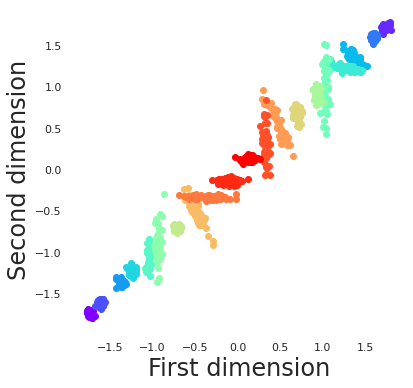

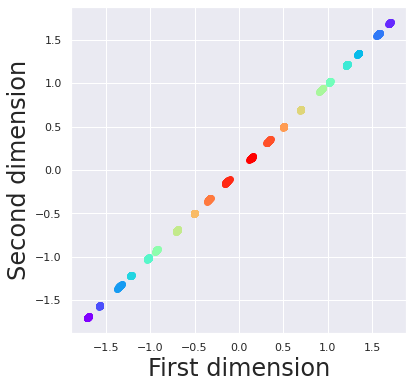

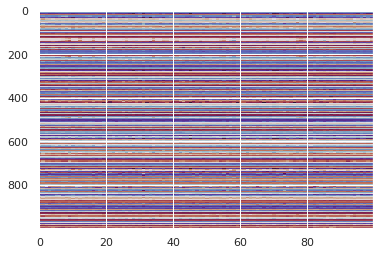

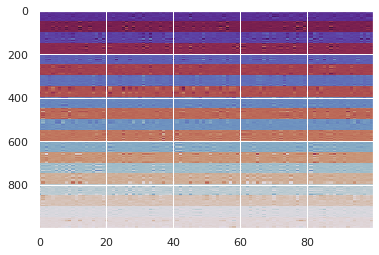

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm

plt.figure(figsize=(6,6))
ax = plt.axes()
ax.set(facecolor = "white")
plt.xlabel('First dimension',fontsize=24)
plt.ylabel('Second dimension',fontsize=24)
colors = cm.rainbow(np.linspace(0, 1, 20))
for i in range(20):
    plt.scatter(X[true_clusters==i,0],X[true_clusters==i,1], c=colors[i])

# plt.figure(figsize=(6,6))
# ax = plt.axes()
# ax.set(facecolor = "white")
# plt.xlabel('First dimension',fontsize=24)
# plt.ylabel('Second dimension',fontsize=24)
# colors = cm.rainbow(np.linspace(0, 1, 20))
# for i in np.arange(12,15):
#     plt.scatter(X[true_clusters==i,0],X[true_clusters==i,3], c=colors[i])

plt.figure(figsize=(6,6))
plt.xlabel('First dimension',fontsize=24)
plt.ylabel('Second dimension',fontsize=24)
colors = cm.rainbow(np.linspace(0, 1, 20))
for i in np.arange(20):
    plt.scatter(Xhat_list[58][true_clusters==i,0],Xhat_list[58][true_clusters==i,3], c=colors[i])

plt.figure()
maxval = np.max(np.abs(X))
plt.imshow(X,aspect='auto',interpolation='nearest',cmap='twilight_shifted',vmin=-1*maxval, vmax=maxval)  

plt.figure()
maxval = np.max(np.abs(X))
plt.imshow(X[np.argsort(true_clusters),:],aspect='auto',interpolation='nearest',cmap='twilight_shifted',vmin=-1*maxval, vmax=maxval)  


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

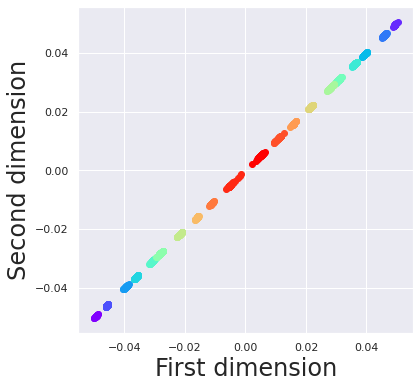

In [6]:
p=50
plt.figure(figsize=(6,6))
plt.xlabel('First dimension',fontsize=24)
plt.ylabel('Second dimension',fontsize=24)
colors = cm.rainbow(np.linspace(0, 1, 20))
for i in np.arange(20):
    plt.scatter(results['U'][p][true_clusters==i,0],results['U'][p][true_clusters==i,0], c=colors[i])



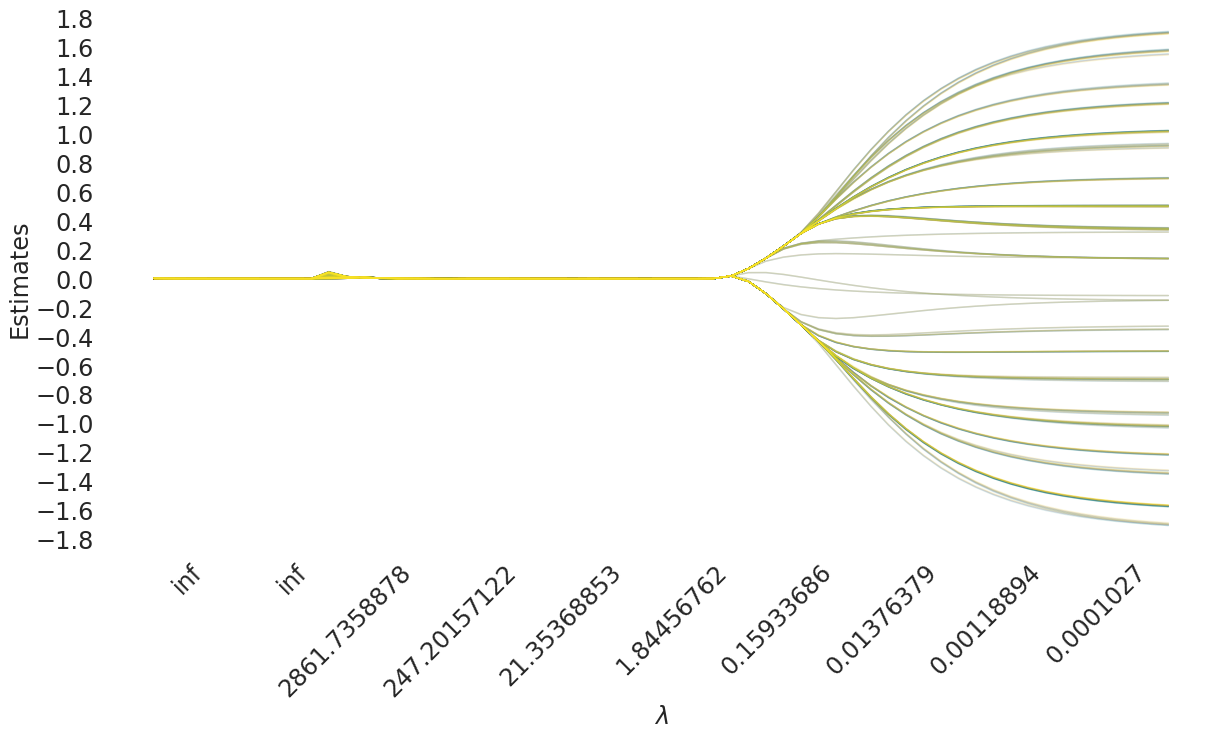

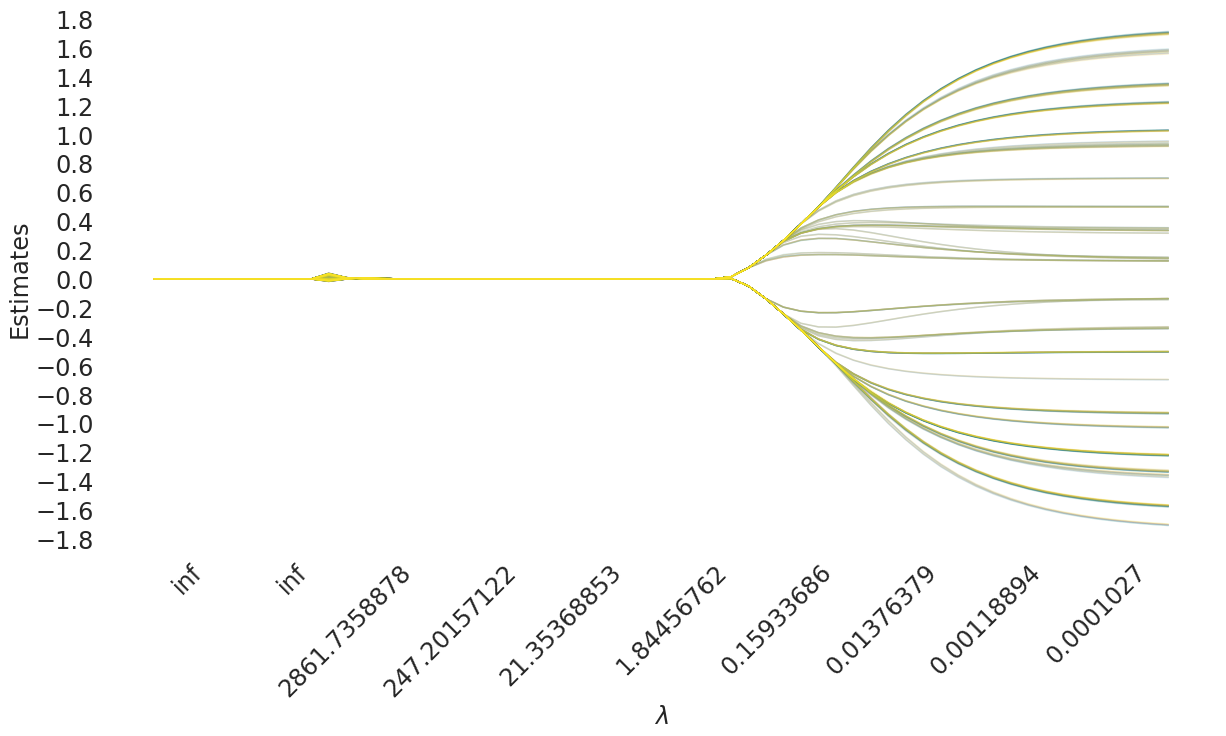

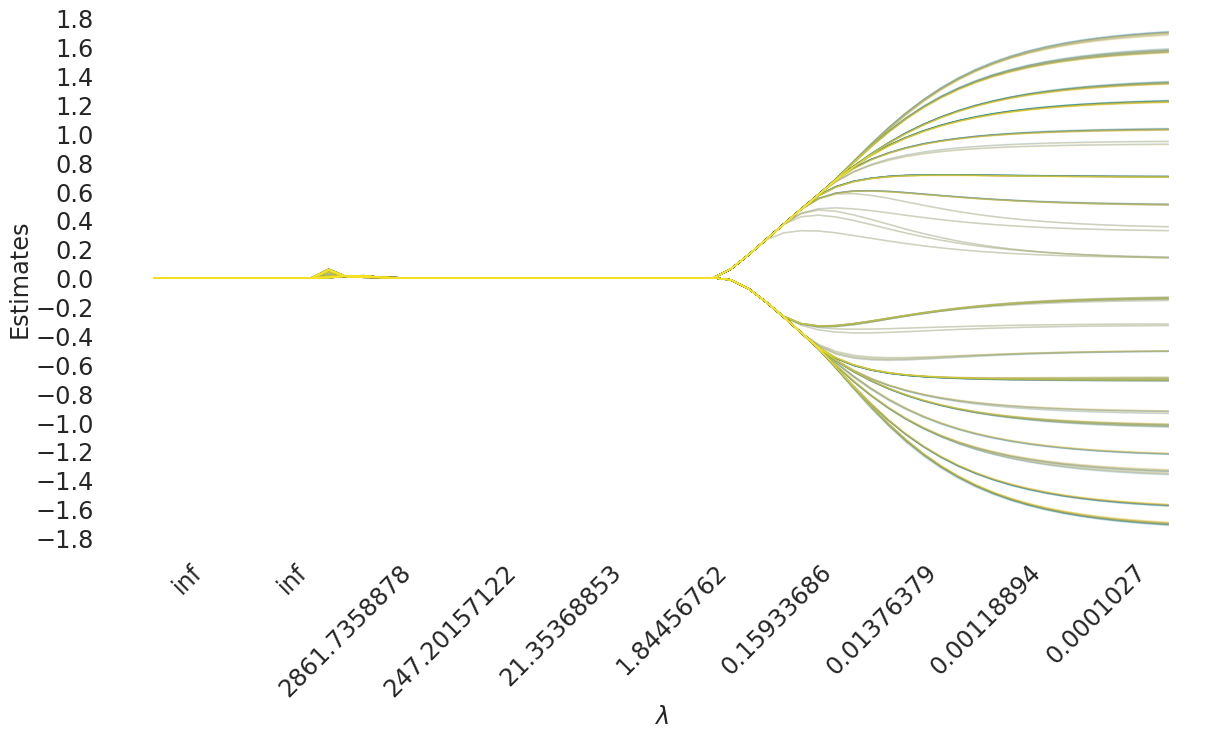

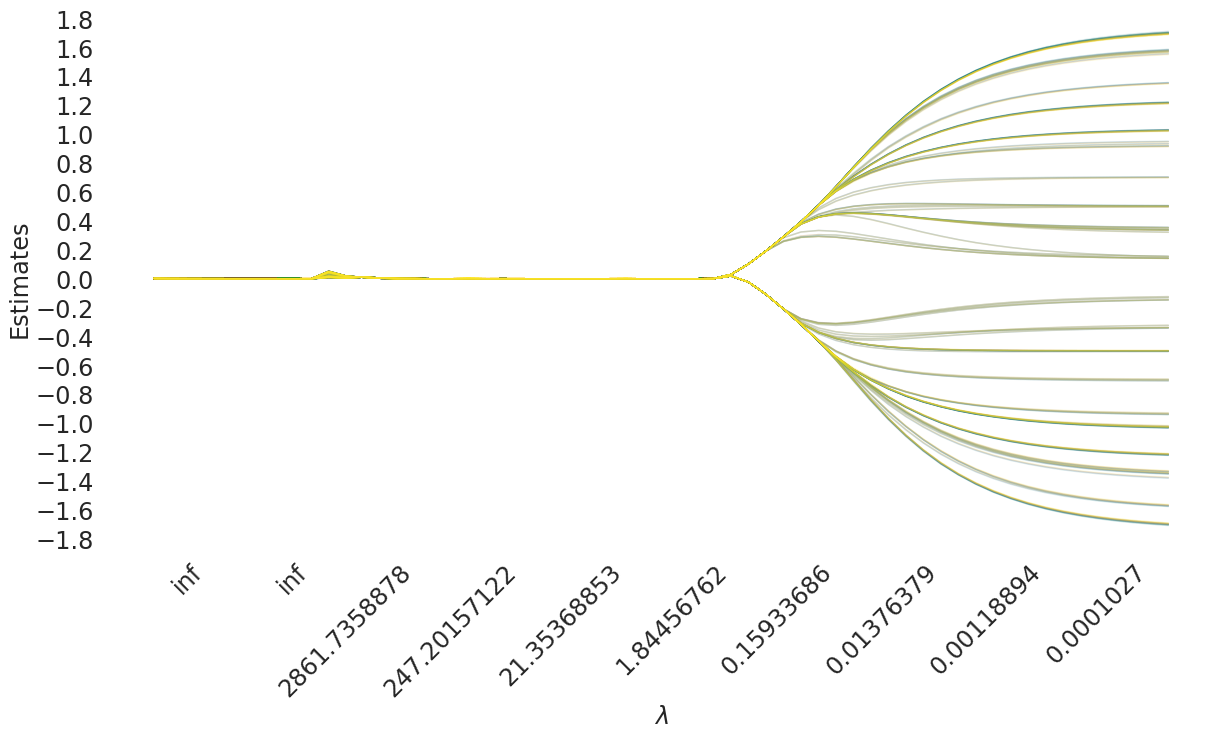

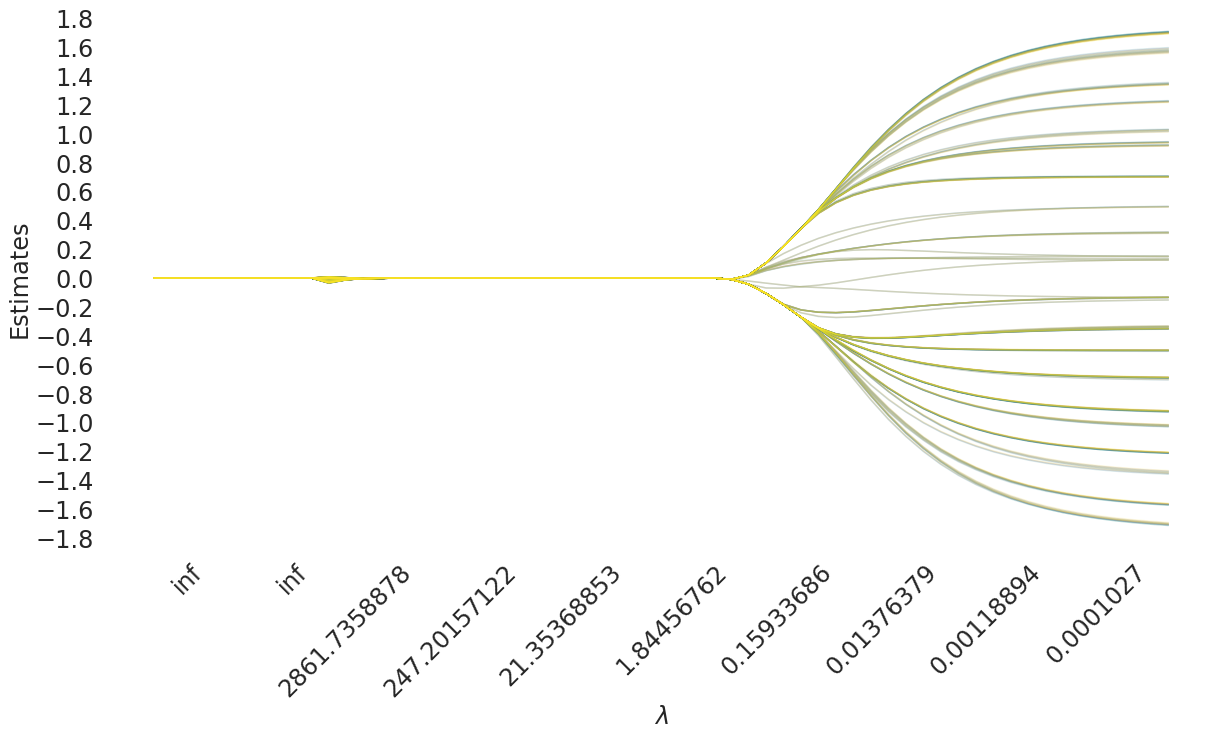

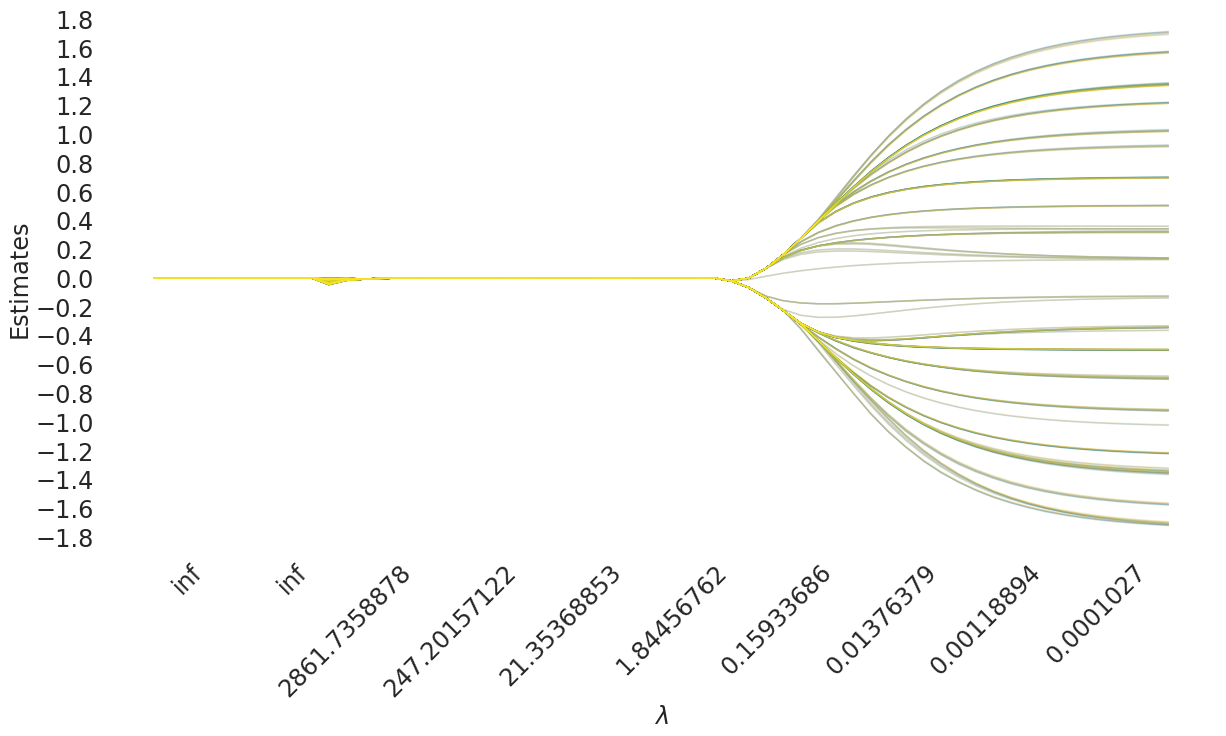

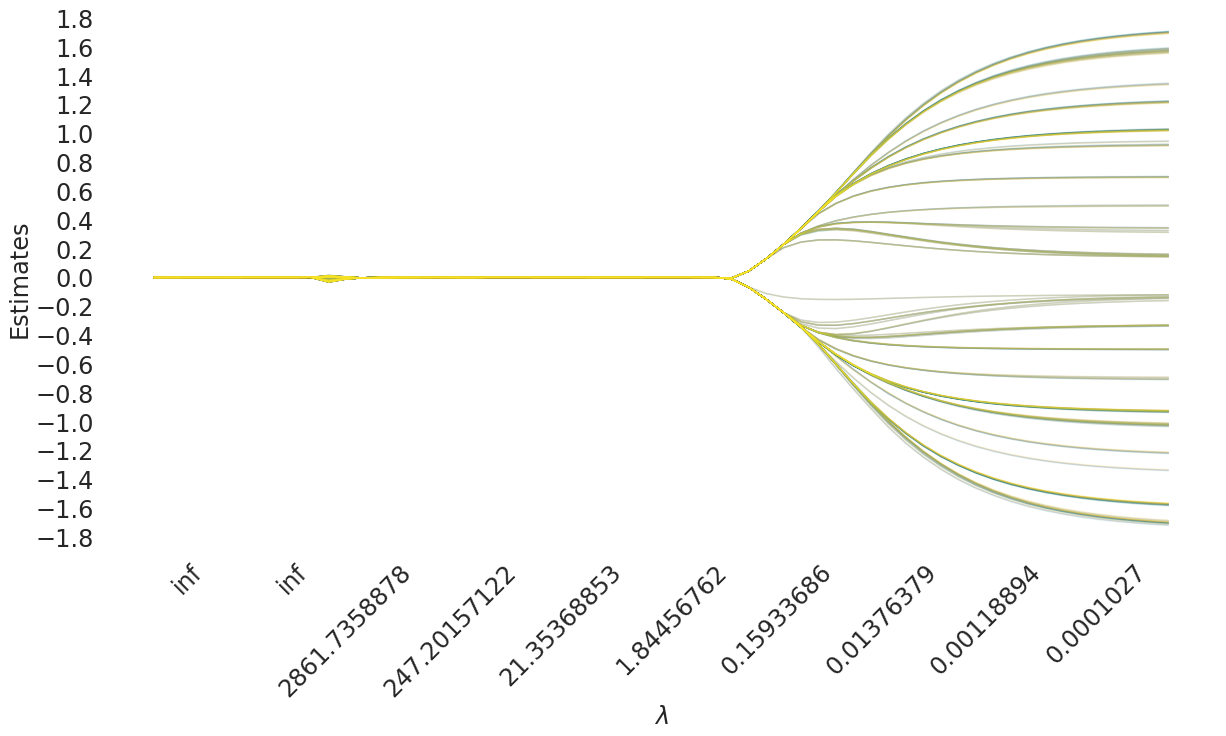

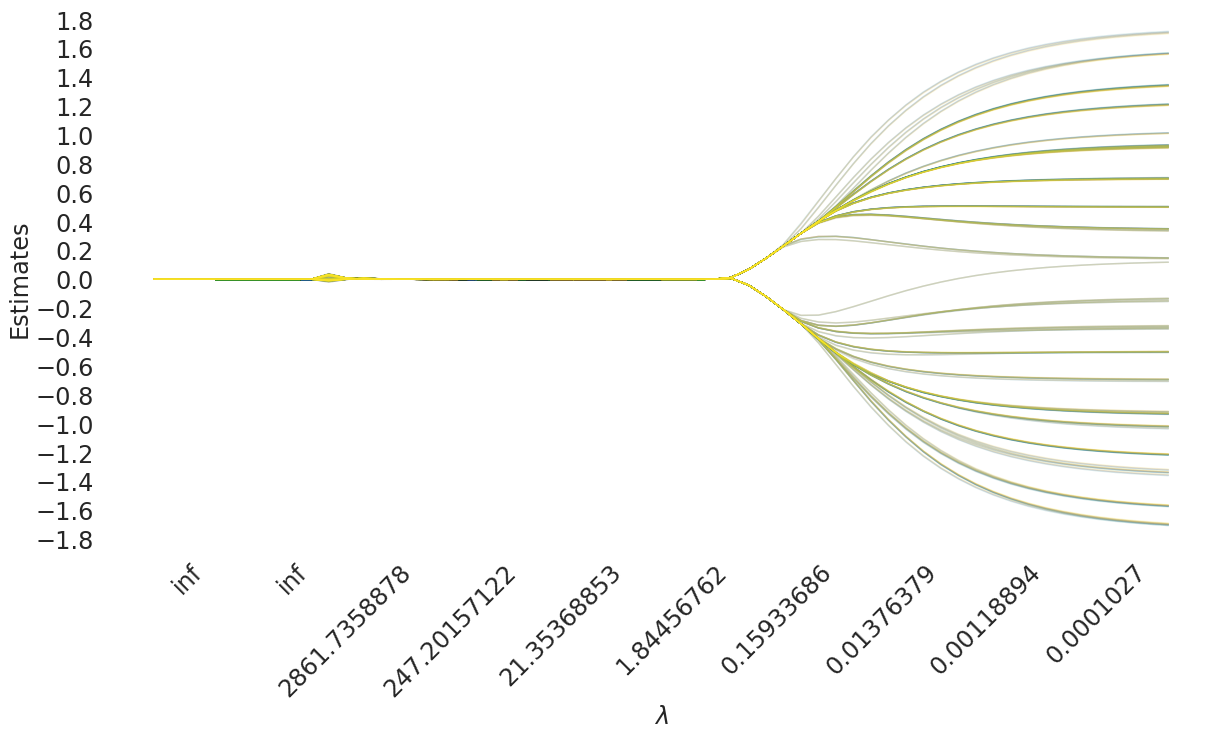

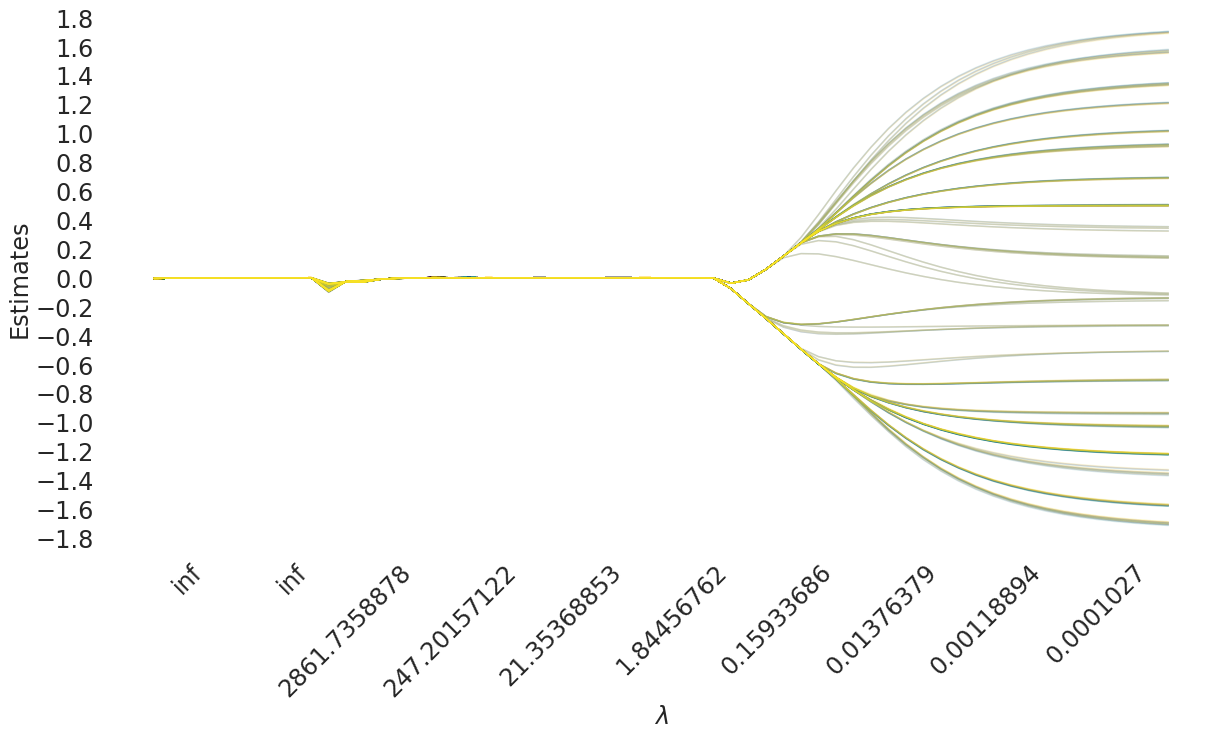

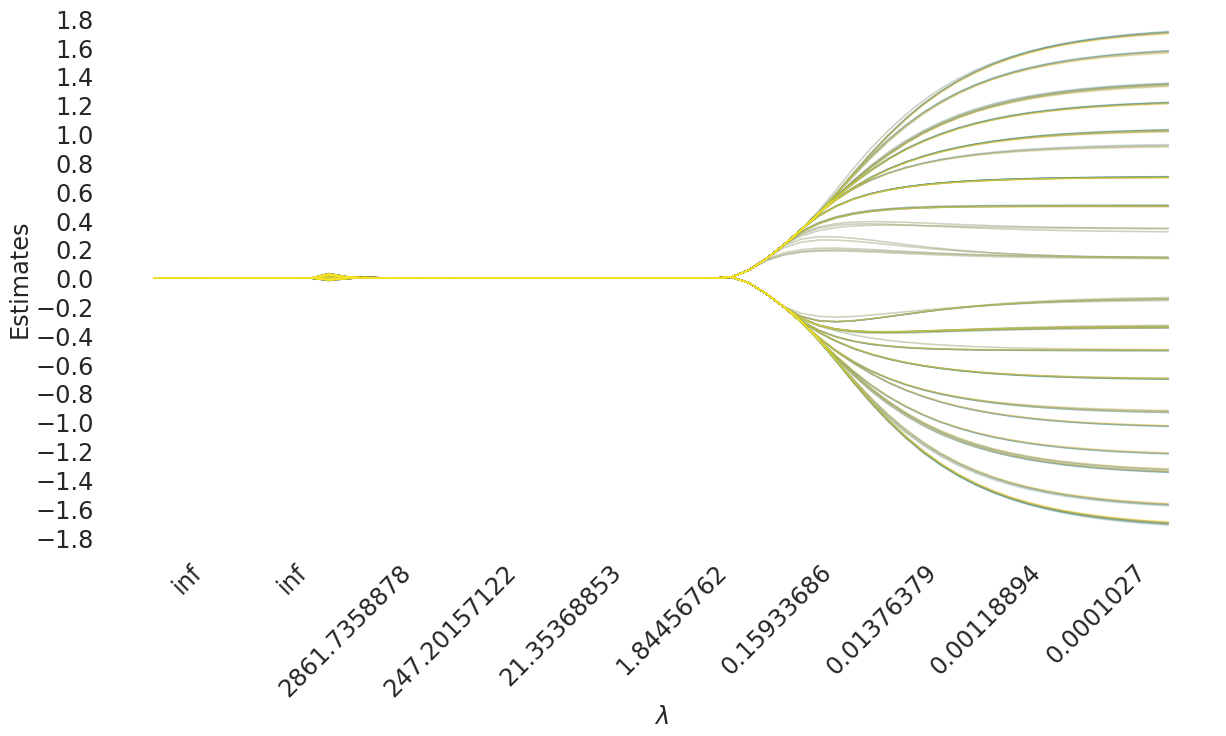

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm
for batch in range(int(X.shape[0]/results['split_size'])):
    inds = np.arange(results['split_size']*batch,results['split_size']*(batch+1))
    path_plot(np.asarray(Xhat_list)[:,inds,0:3], penalty_list, plot_range=[0,-1])
    plt.ylabel("Estimates")
    plt.locator_params(nbins=25)
    # ax = plt.axes()
    # ax.set(facecolor = "white")


In [8]:
sgn = np.ones((len(penalty_list), 1000))
s = np.sign(np.array(results['U'])[59,:]).T[0].T

sgn = np.tile(s,(len(penalty_list),1))
print(sgn.shape)
for p in range(len(penalty_list)):
    tr = np.where((np.sign(np.array(results['U'])[10,:]) != np.sign(np.array(results['U'])[59,:]).T)[0])
    sgn[p,tr] = np.atleast_2d(np.sign(np.array(results['U'])[59,tr[0]])).T
sgn.shape = (60,1000,1)

(60, 1000)


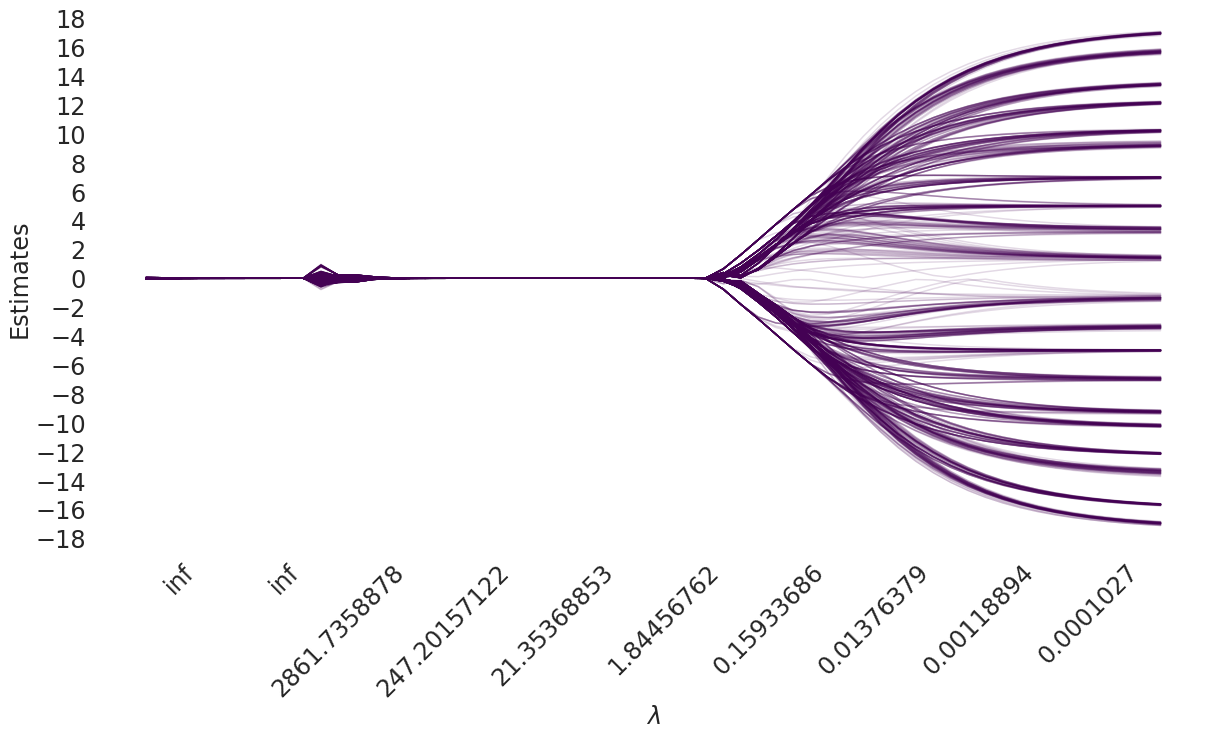

In [9]:
path_plot(sgn*np.abs(np.array(results['U'])[:,:])*np.array(results['S']), penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)


Batch: 0 Best IDX 50 ACC: 1.0 ARI: 1.0 NMI: 1.0


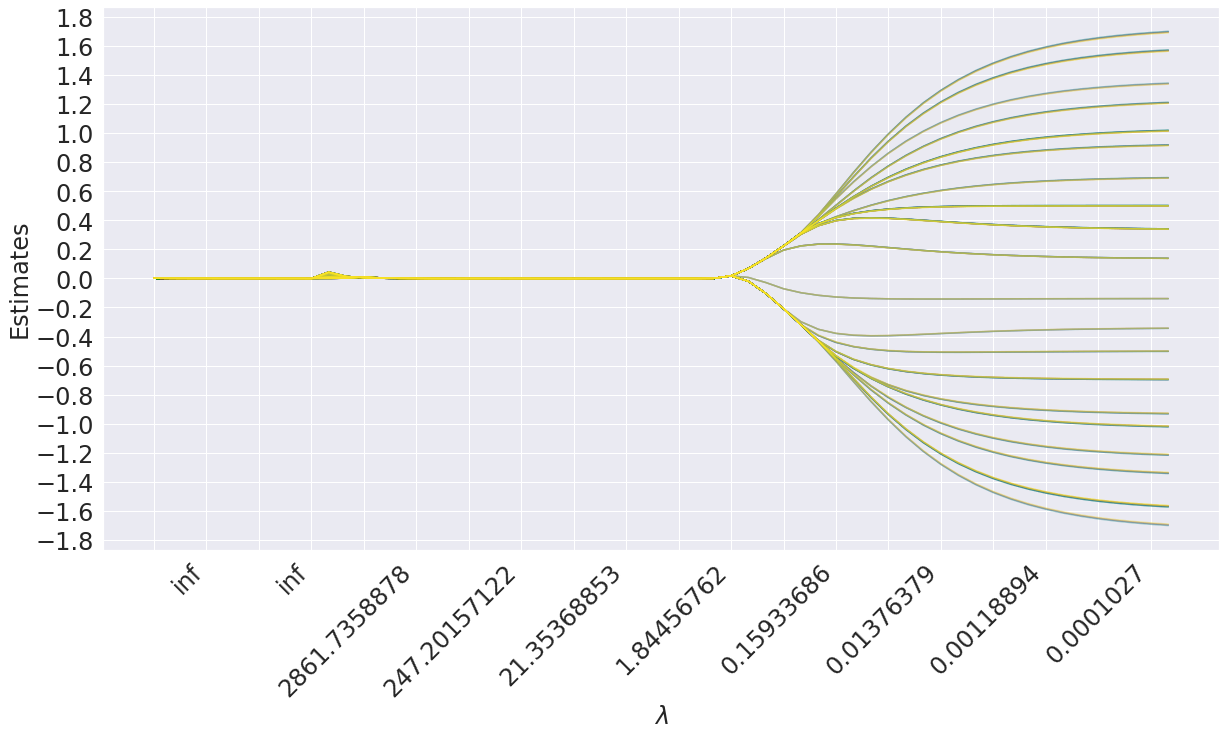

In [30]:
batch = 0
inds = np.arange(results['split_size']*batch,results['split_size']*(batch+1))
component = sgn*np.abs(np.array(results['U'])[:,:])*np.array(results['S'])
# path_plot(component, penalty_list, plot_range=[0,-1])
# plt.ylabel("Estimates")
# plt.locator_params(nbins=25)
p=50
labels, ari, nmi, acc = fit_pcmf(Xhat_list[p][inds,:], true_clusters[inds], 20, results['gauss_coef'])
print('Batch:',batch,'Best IDX',p,'ACC:',acc,'ARI:',ari,'NMI:',nmi)

centroids = []
for p in range(0,len(penalty_list)):
    centroids.append(centroid_matrix(np.array(Xhat_list[p][inds,:]),labels))

path_plot(np.asarray(centroids)[:,:,0:3], penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)


In [31]:
inds = np.arange(results['split_size']*batch,results['split_size']*(batch+1))
centroids = []
for p in range(40,len(penalty_list)):
    labels, ari, nmi, acc = fit_pcmf(Xhat_list[p][inds,:], true_clusters[inds], 20, results['gauss_coef'])
    print('Batch:',batch,'Best IDX',p,'ACC:',acc,'ARI:',ari,'NMI:',nmi)
    centroids.append(centroid_matrix(np.array(Xhat_list[p][inds,:]),labels))

path_plot(np.asarray(centroids)[:,:,5:6], penalty_list[40:], plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)


Batch: 0 Best IDX 40 ACC: 0.78 ARI: 0.7285973507675634 NMI: 0.9145809620149074
Batch: 0 Best IDX 41 ACC: 0.78 ARI: 0.6501291287209461 NMI: 0.9111710074862297
Batch: 0 Best IDX 42 ACC: 0.82 ARI: 0.7330087016871542 NMI: 0.9264145485910518
Batch: 0 Best IDX 43 ACC: 0.95 ARI: 0.905670077050507 NMI: 0.9666047228460336
Batch: 0 Best IDX 44 ACC: 0.99 ARI: 0.9704232304726675 NMI: 0.9900563382005194
Batch: 0 Best IDX 45 ACC: 1.0 ARI: 1.0 NMI: 1.0
Batch: 0 Best IDX 46 ACC: 1.0 ARI: 1.0 NMI: 1.0
Batch: 0 Best IDX 47 ACC: 1.0 ARI: 1.0 NMI: 1.0
Batch: 0 Best IDX 48 ACC: 0.92 ARI: 0.855719612033752 NMI: 0.9756539278353393
Batch: 0 Best IDX 49 ACC: 1.0 ARI: 1.0 NMI: 1.0
Batch: 0 Best IDX 50 ACC: 1.0 ARI: 1.0 NMI: 1.0
Batch: 0 Best IDX 51 ACC: 1.0 ARI: 1.0 NMI: 1.0
Batch: 0 Best IDX 52 ACC: 1.0 ARI: 1.0 NMI: 1.0000000000000002


KeyboardInterrupt: 

In [12]:
for batch in range(int(X.shape[0]/results['split_size'])):
    for best_idx in range(55,len(penalty_list)):
        inds = np.arange(results['split_size']*batch,results['split_size']*(batch+1))
        labels, ari, nmi, acc = fit_pcmf(Xhat_list[best_idx][inds,:], true_clusters[inds], 20, results['gauss_coef'])
#         labels, ari, nmi, acc = fit_spectral(Xhat_list[best_idx][inds,:], true_clusters[inds], 20)
        print('Batch:',batch,'Best IDX',best_idx,'ACC:',acc,'ARI:',ari,'NMI:',nmi)


Batch: 0 Best IDX 55 ACC: 1.0 ARI: 1.0 NMI: 1.0
Batch: 0 Best IDX 56 ACC: 1.0 ARI: 1.0 NMI: 1.0
Batch: 0 Best IDX 57 ACC: 1.0 ARI: 1.0 NMI: 1.0
Batch: 0 Best IDX 58 ACC: 0.92 ARI: 0.8985093769221709 NMI: 0.9778504645448174
Batch: 0 Best IDX 59 ACC: 0.88 ARI: 0.7945609899066828 NMI: 0.9549252730470911
Batch: 1 Best IDX 55 ACC: 0.09 ARI: 0.0020776522529541617 NMI: 0.03782162020698984
Batch: 1 Best IDX 56 ACC: 0.09 ARI: 0.0020776522529541617 NMI: 0.03782162020698984
Batch: 1 Best IDX 57 ACC: 0.09 ARI: 0.0020776522529541617 NMI: 0.03782162020698984
Batch: 1 Best IDX 58 ACC: 0.09 ARI: 0.0020776522529541617 NMI: 0.03782162020698984
Batch: 1 Best IDX 59 ACC: 0.09 ARI: 0.0020776522529541617 NMI: 0.03782162020698984
Batch: 2 Best IDX 55 ACC: 0.93 ARI: 0.9269711467532193 NMI: 0.9807491052852003
Batch: 2 Best IDX 56 ACC: 0.87 ARI: 0.7813044140086951 NMI: 0.953000368971991
Batch: 2 Best IDX 57 ACC: 1.0 ARI: 1.0 NMI: 1.0
Batch: 2 Best IDX 58 ACC: 0.84 ARI: 0.7177653468134741 NMI: 0.9458850892560242

In [32]:
for best_idx in range(55,len(penalty_list)):
    labels, ari, nmi, acc = fit_pcmf(Xhat_list[best_idx], true_clusters, 20, results['gauss_coef'])
    print('Best IDX',best_idx,'ACC:',acc,'ARI:',ari,'NMI:',nmi)


Best IDX 55 ACC: 1.0 ARI: 1.0 NMI: 0.9999999999999997


KeyboardInterrupt: 

In [33]:
centroids = []
p=55
labels, ari, nmi, acc = fit_pcmf(Xhat_list[p], true_clusters, 20, results['gauss_coef'])


In [34]:
print('Best IDX',p,'ACC:',acc,'ARI:',ari,'NMI:',nmi)
for p in range(len(penalty_list)):
    centroids.append(centroid_matrix(np.array(Xhat_list[p]),labels))



Best IDX 55 ACC: 1.0 ARI: 1.0 NMI: 0.9999999999999997


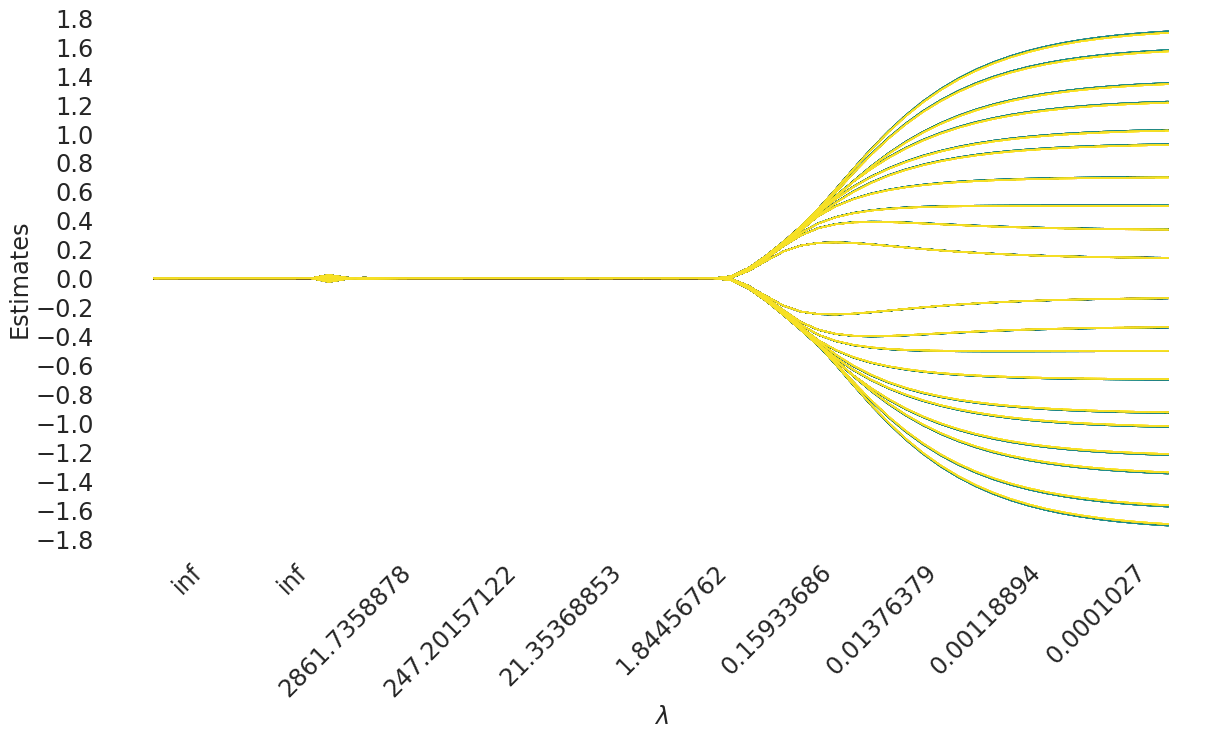

In [37]:
path_plot(np.asarray(centroids)[:,:,0:3], penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)

In [ ]:
component = sgn*np.abs(np.array(results['U'])[:,:])*np.array(results['S'])


In [38]:
n_clusts, ics, centroids = cluster_path(X, np.array(Xhat_list), penalty_list[:], float(results['gauss_coef']), int(results['neighbors']), verbose=True)


ValueError: operands could not be broadcast together with shapes (100,100) (1000,100) 

In [10]:
from sklearn.utils.extmath import randomized_svd
from pcmf import SVD
U_svd = np.zeros((X.shape[0],1))
S_svd = np.zeros((20,1))
V_svd = np.zeros((20,X.shape[1]))
for i in range(20):
    inds = true_clusters==i
#     U,S,V = SVD(X[inds,:],return_rank=1)
    U, S, V = randomized_svd(X[inds,:], n_components=1,random_state=1234)
    U_svd[inds,:] = U
    S_svd[i,:] = S
    V_svd[i,] = V

In [11]:
(U_svd[true_clusters==i,:] * S_svd[0,:]).T

array([[14.57684041, 17.92077711, 17.04226774, 22.66884262, 22.2308524 ,
        15.98044565, 23.41656084, 17.61579945, 30.85143591, 12.62721628,
        15.1511786 , 13.7447446 , 27.75132105, 15.87813246, 12.65540492,
        19.28513414, 14.22110095, 11.52876335, 12.4480295 , 17.74651417,
        15.73053455, 11.93489667, 15.16806373, 13.55618171, 23.76986743,
        18.62269904, 16.16819972, 18.55174303, 17.4066961 , 15.34610015,
        11.58905341, 12.64089572, 16.0536748 , 21.37059659, 23.67516386,
        20.96342019, 14.93283325, 14.78414558, 14.47085236,  6.87262981,
        13.54488707, 13.12328616, 19.23211816, 14.75311799, 19.08687835,
        16.82839492, 21.25620293, 12.35406489, 15.19819387, 15.08727187]])

In [12]:
V_svd[i]

array([0.08286661, 0.09290821, 0.09768045, 0.09308643, 0.09060916,
       0.0921826 , 0.10393985, 0.11340004, 0.14651233, 0.18269121,
       0.09615342, 0.09470476, 0.16004212, 0.08930652, 0.09243477,
       0.09114892, 0.13975814, 0.0954153 , 0.08464749, 0.09579577,
       0.13356864, 0.10425501, 0.08949363, 0.09231987, 0.08590083,
       0.09470438, 0.12315398, 0.09343063, 0.09603732, 0.05124103,
       0.0938811 , 0.0846061 , 0.09395836, 0.0925415 , 0.15684705,
       0.09116487, 0.0926005 , 0.12592712, 0.11717779, 0.0930047 ,
       0.08647492, 0.12210286, 0.09206883, 0.07674633, 0.09311766,
       0.0559873 , 0.09533347, 0.09759322, 0.10639356, 0.0945121 ,
       0.09508059, 0.09090461, 0.09198617, 0.09501318, 0.11916752,
       0.13295917, 0.08823359, 0.04905832, 0.00853086, 0.09420783,
       0.09165274, 0.0950793 , 0.09068198, 0.08988528, 0.09004498,
       0.05425784, 0.09174588, 0.08962743, 0.1148011 , 0.0930028 ,
       0.06902852, 0.09676013, 0.08721276, 0.09739758, 0.05328

In [13]:
(results['U'][p,true_clusters==i,:] * results['S'][p]).T[0]

array([1.35532377, 1.35508163, 1.37402986, 1.39313643, 1.41030245,
       1.22860439, 1.49181147, 1.45749179, 1.25737064, 1.38000113,
       1.24385449, 1.38944129, 1.39709587, 1.43238857, 1.37515009,
       1.39595838, 1.39588194, 1.41522851, 1.54973263, 1.49840177,
       1.27647408, 1.51917219, 1.35139205, 1.22873698, 1.47706551,
       1.26484531, 1.30179363, 1.33484345, 1.37735399, 1.36903691,
       1.41045318, 1.42859188, 1.59421135, 1.48482842, 1.44052595,
       1.50835235, 1.56653602, 1.47335401, 1.4167978 , 1.4650863 ,
       1.20348136, 1.34129057, 1.43342985, 1.49796992, 1.37764207,
       1.34280159, 1.43461262, 1.4194129 , 1.418825  , 1.37329113])

In [14]:
results['V'][p,:,:]

array([[0.10027249, 0.10057613, 0.10000282, 0.09983303, 0.09981069,
        0.10016995, 0.09966114, 0.09967305, 0.10034221, 0.10057082,
        0.09994771, 0.10006694, 0.10027422, 0.099968  , 0.09978207,
        0.09975889, 0.10002312, 0.09968556, 0.09997175, 0.10003809,
        0.09999382, 0.10016889, 0.10047268, 0.09927206, 0.10005771,
        0.09937465, 0.09975548, 0.09979306, 0.10036841, 0.09981883,
        0.09983677, 0.10048146, 0.09950359, 0.09956585, 0.10041065,
        0.10048487, 0.09970586, 0.10019923, 0.09988479, 0.09969501,
        0.0999938 , 0.1004344 , 0.09988627, 0.10029003, 0.10020783,
        0.09972899, 0.1001675 , 0.09940461, 0.09959625, 0.099752  ,
        0.09972961, 0.10004221, 0.10046699, 0.09962333, 0.09996448,
        0.10009703, 0.10023979, 0.10029122, 0.09957035, 0.10008968,
        0.10022952, 0.10025837, 0.10025444, 0.09993343, 0.10021695,
        0.10017756, 0.0999328 , 0.09976212, 0.09975354, 0.09967046,
        0.0997011 , 0.09990058, 0.10014114, 0.09

In [15]:
results['V'][p,:,:] * results['U'][p,true_clusters==i,:] * results['S'][p]

array([[0.13590169, 0.13631321, 0.1355362 , ..., 0.13527226, 0.13580612,
        0.13534217],
       [0.13587741, 0.13628886, 0.13551199, ..., 0.13524809, 0.13578186,
        0.13531799],
       [0.1377774 , 0.1381946 , 0.13740686, ..., 0.13713927, 0.13768051,
        0.13721015],
       ...,
       [0.14232807, 0.14275905, 0.1419453 , ..., 0.14166887, 0.14222798,
        0.14174209],
       [0.14226912, 0.14269992, 0.1418865 , ..., 0.14161019, 0.14216907,
        0.14168338],
       [0.13770333, 0.1381203 , 0.13733299, ..., 0.13706554, 0.13760649,
        0.13713638]])

In [16]:
U_svd[true_clusters==i,:].shape

(50, 1)

In [17]:
A_svd = np.zeros((X.shape[0],X.shape[1]))
for i in range(20):
    inds = true_clusters==i
    A_svd[inds,:] = np.dot((U_svd[true_clusters==i,:] * S_svd[0,:]), V_svd[i:i+1])
    print(A_svd[inds,:])

[[-1.74578773 -1.7469278  -1.73414312 ... -1.7460301  -1.76529906
  -1.76411023]
 [-1.73747201 -1.73860665 -1.72588286 ... -1.73771322 -1.7568904
  -1.75570723]
 [-1.7309699  -1.73210029 -1.71942412 ... -1.73121021 -1.75031562
  -1.74913688]
 ...
 [-1.73565087 -1.73678432 -1.72407387 ... -1.73589183 -1.75504891
  -1.75386698]
 [-1.73023016 -1.73136007 -1.71868932 ... -1.73047037 -1.74956762
  -1.74838938]
 [-1.74034576 -1.74148227 -1.72873744 ... -1.74058737 -1.75979627
  -1.75861114]]
[[1.74684311 1.73888615 1.74898904 ... 1.75296495 1.76517879 1.74974965]
 [1.7428445  1.73490576 1.74498552 ... 1.74895233 1.76113821 1.7457444 ]
 [1.73825169 1.73033386 1.74038706 ... 1.74434342 1.75649718 1.74114394]
 ...
 [1.73852667 1.7306076  1.74066238 ... 1.74461937 1.75677506 1.74141938]
 [1.73942175 1.7314986  1.74155857 ... 1.74551759 1.75767954 1.74231595]
 [1.7483664  1.74040251 1.7505142  ... 1.75449358 1.76671807 1.75127548]]
[[-1.73778258 -1.7421425  -1.74625718 ... -1.74242651 -1.7434647


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

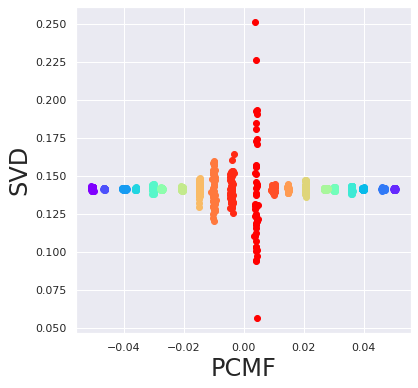

In [18]:
plt.figure(figsize=(6,6))
plt.xlabel('PCMF',fontsize=24)
plt.ylabel('SVD',fontsize=24)
colors = cm.rainbow(np.linspace(0, 1, 20))
for i in np.arange(20):
    inds = true_clusters==i
    U, S, V = randomized_svd(X[inds,:], n_components=1,random_state=1234)
#     U, S, V = randomized_svd(X, n_components=1,random_state=1234)
#     U = U[inds,:]
    plt.scatter(results['U'][p][true_clusters==i,0],U, c=colors[i])
#     plt.scatter(Xhat_list[p][true_clusters==i,0],np.dot((U*S),V)[:,0], c=colors[i])
#     plt.scatter(Xhat_list[p][true_clusters==i,0],A_svd[true_clusters==i,0], c=colors[i])


In [19]:
(results['U'][p][true_clusters==i,0:1]@results['V'][p]*SS).shape

NameError: name 'SS' is not defined

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

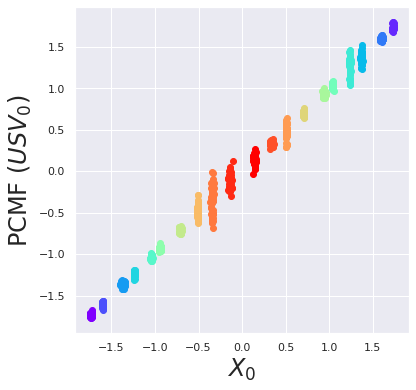

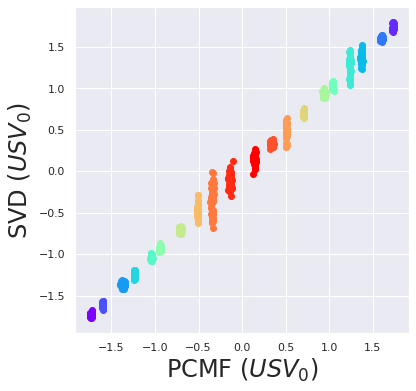

In [20]:
plt.figure(figsize=(6,6))
plt.xlabel('${X_0}$',fontsize=24)
plt.ylabel('PCMF (${USV_0}$)',fontsize=24)
colors = cm.rainbow(np.linspace(0, 1, 20))
for i in np.arange(20):
    inds = true_clusters==i
    U, S, V = randomized_svd(X[inds,:], n_components=1,random_state=1234)
#     U, S, V = randomized_svd(X, n_components=1,random_state=1234)
#     U = U[inds,:]
    SS = (results['U'][p].T@X)@results['V'][p].T
    plt.scatter((results['U'][p][true_clusters==i,0:1]@results['V'][p]*SS)[:,0:1], X[true_clusters==i,0:1], c=colors[i])
#     plt.scatter(results['U'][p][true_clusters==i,0:1]@results['V'][p]*SS, (U*S)@V, c=colors[i])
#     plt.scatter(Xhat_list[p][true_clusters==i,0],np.dot((U*S),V)[:,0], c=colors[i])
#     plt.scatter(Xhat_list[p][true_clusters==i,0],A_svd[true_clusters==i,0], c=colors[i])
plt.figure(figsize=(6,6))
plt.xlabel('PCMF (${USV_0}$)',fontsize=24)
plt.ylabel('SVD (${USV_0}$)',fontsize=24)
for i in np.arange(20):
    inds = true_clusters==i
    U, S, V = randomized_svd(X[inds,:], n_components=1,random_state=1234)
#     U, S, V = randomized_svd(X, n_components=1,random_state=1234)
#     U = U[inds,:]
    SS = (results['U'][p].T@X)@results['V'][p].T
    plt.scatter((results['U'][p][true_clusters==i,0:1]@results['V'][p]*SS)[:,0:1], X[true_clusters==i,0:1], c=colors[i])
#     plt.scatter(results['U'][p][true_clusters==i,0:1]@results['V'][p]*SS, (U*S)@V, c=colors[i])
#     plt.scatter(Xhat_list[p][true_clusters==i,0],np.dot((U*S),V)[:,0], c=colors[i])
#     plt.scatter(Xhat_list[p][true_clusters==i,0],A_svd[true_clusters==i,0], c=colors[i])


In [21]:
(results['U'][p].T@X)@results['V'][p].T

# (results['U'][p].T@X[])@results['V'][p].T
# results['S'][p]

U, S, V = randomized_svd(X[results['true_clusters']==i,:], n_components=1,random_state=1234)
inds = (results['true_clusters']==0)

(results['U'][p][inds].T@X[inds,:])@results['V'][p].T

(results['U'][p][inds,0:1].T@X[inds,:])@results['V'][p].T

array([[43.71847248]])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

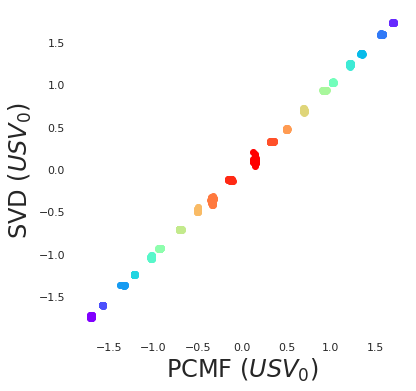

In [28]:
plt.figure(figsize=(6,6))
ax = plt.axes()
ax.set(facecolor = "white")
plt.xlabel('PCMF (${USV_0}$)',fontsize=24)
plt.ylabel('SVD (${USV_0}$)',fontsize=24)
colors = cm.rainbow(np.linspace(0, 1, 20))
for i in np.arange(20):
    inds = (results['true_clusters']==i)
    # Compute SVD for first component with cluster (no recentering):
    U, S, V = randomized_svd(X[inds,:], n_components=1,random_state=1234)
    
#     For PCMF, recalculate S within cluster using only the X/U in the cluster:
#     SS = (results['U'][p][inds].T@X[inds,:])@results['V'][p].T
    SS = (results['U'][p].T@X)@results['V'][p].T
#     SS = (results['U'][p][inds,0:1].T@X[inds,:])@results['V'][p].T
    
    plt.scatter(results['A'][p][inds,0:1], (U@V*S)[:,0:1], c=colors[i])
#     plt.scatter((results['U'][p][inds,0:1]@results['V'][p]*SS)[:,0:1], (U@V*S)[:,0:1], c=colors[i])
#     plt.scatter((results['U'][p][inds,0:1]@results['V'][p]*SS)[:,0:1], X[inds,0:1], c=colors[i])

#     plt.scatter((results['U'][p][inds,0:1]@results['V'][p]*SS)[:,0:1], X[inds,0:1], c=colors[i])


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

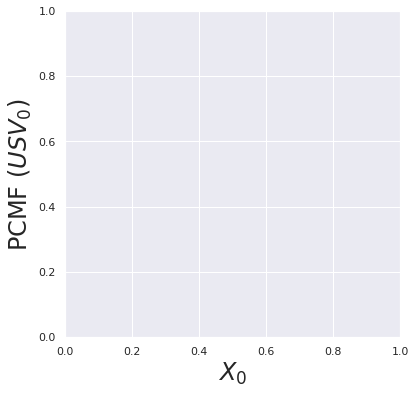

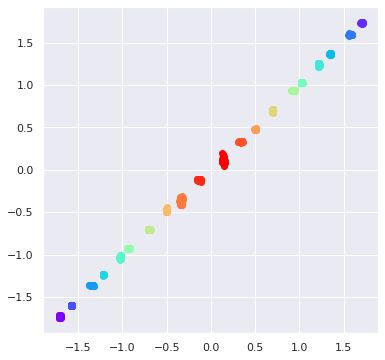

In [23]:
plt.figure(figsize=(6,6))
plt.xlabel('${X_0}$',fontsize=24)
plt.ylabel('PCMF (${USV_0}$)',fontsize=24)
colors = cm.rainbow(np.linspace(0, 1, 20))
for i in np.arange(20):
    inds = (results['true_clusters']==i)
    # Compute SVD for first component with cluster (no recentering):
    U, S, V = randomized_svd(X[inds,:], n_components=1,random_state=1234)
    
#     For PCMF, recalculate S within cluster using only the X/U in the cluster:
#     SS = (results['U'][p][inds].T@X[inds,:])@results['V'][p].T
    SS = (results['U'][p].T@X)@results['V'][p].T
    
plt.figure(figsize=(6,6))
# plt.xlabel('${X_0}$',fontsize=24)
# plt.ylabel('PCMF (${USV_0}$)',fontsize=24)
colors = cm.rainbow(np.linspace(0, 1, 20))
for i in np.arange(20):
    inds = (results['true_clusters']==i)
    # Compute SVD for first component with cluster (no recentering):
    U, S, V = randomized_svd(X[inds,:], n_components=1,random_state=1234)
    
#     For PCMF, recalculate S within cluster using only the X/U in the cluster:
#     SS = (results['U'][p][inds].T@X[inds,:])@results['V'][p].T
    SS = (results['U'][p].T@X)@results['V'][p].T
    
    plt.scatter((results['U'][p][inds,0:1]@results['V'][p]*results['S'][p])[:,0:1], (U@V*S)[:,0:1], c=colors[i])
#     plt.scatter((results['U'][p][inds,0:1]@results['V'][p]*SS)[:,0:1], (U@V*S)[:,0:1], c=colors[i])
#     plt.scatter((results['U'][p][inds,0:1]@results['V'][p]*SS)[:,0:1], X[inds,0:1], c=colors[i])

#     plt.scatter((results['U'][p][inds,0:1]@results['V'][p]*SS)[:,0:1], X[inds,0:1], c=colors[i])
#     plt.scatter((results['U'][p][inds,0:1]@results['V'][p]*SS)[:,0:1], X[inds,0:1], c=colors[i])

#     plt.scatter((results['U'][p][inds,0:1]@results['V'][p]*SS)[:,0:1], X[inds,0:1], c=colors[i])
# 

In [24]:
true_clusters = results['true_clusters']
p=58 # penalty

# UPDATING PCMF:
# Reset V to be what is capturing sign differences (important due to sign ambiguity between U and V)
Vv=np.tile(results['V'][p],(X.shape[0],1))*np.sign(results['U'][p])

U_pcmf_cluster=np.zeros((X.shape[0],1))
V_pcmf_cluster=np.zeros((20,X.shape[1]))
S_pcmf_cluster=np.zeros((20,1))
U_SVD_cluster=np.zeros((X.shape[0],1))
V_SVD_cluster=np.zeros((20,X.shape[1]))
S_SVD_cluster=np.zeros((20,1))
for m in range(20):
    # Get indices to subjects in cluster m
    inds = true_clusters==m
    
    # UPDATING PCMF WITHIN CLUSTER:
    # Set all PCMFV to be the same within that cluster
    V_pcmf_cluster[m,:] = np.mean(Vv[inds,:])
    
    # Set U to magnitude since we reset V to be what is capturing sign differences
    Uu = np.abs(results['U'][p][inds])
    
    # For PCMF U within cluster m, normalize to unit vector
    U_pcmf_cluster[inds] = np.sqrt(1./np.sum(Uu**2))*Uu # Unit vector
    
    # Recalculate PCMF S within cluster using normalized U
    S_pcmf_cluster[m] = U_pcmf_cluster[inds].T@X[inds,:]@V_pcmf_cluster[m,:].T
    
    # CALCULATING STANDARD SVD WITHIN CLUSTER
    # Calculate standard SVD for 1st component within cluster m
    U, S, V = randomized_svd(X[inds,:], n_components=1,random_state=1234)

    U_SVD_cluster[inds] = U
    S_SVD_cluster[m] = S
    V_SVD_cluster[m,:] = V
    
print('S_PCMF:',S_pcmf_cluster.T)
print('S_SVD:',S_SVD_cluster.T)
print('')
print('U_PCMF[0:20]:',U_pcmf_cluster[0:20].T)
print('U_SVD[0:20]:',U_SVD_cluster[0:20].T)
print('')
print('V_PCMF[0:3,0:10].flatten():',V_pcmf_cluster[0:3,0:10].flatten() )
print('V_SVD[0:3,0:10].flatten():', V_SVD_cluster[0:3,0:10].flatten() )
print('')
print('PCMF S within clusters is equal to SVD S within clusters:', np.alltrue(np.round(S_pcmf_cluster,0)==np.round(S_pcmf_cluster,0)))
print('PCMF U within clusters is equal to SVD U within clusters:', np.alltrue(np.round(U_pcmf_cluster,2)==np.round(U_SVD_cluster,2)))
print('PCMF V within clusters is equal to SVD V within clusters:', np.alltrue(np.round(V_pcmf_cluster,1)==np.round(V_SVD_cluster,1)))


# print(np.vstack((S_pcmf_cluster.T,S_SVD_cluster.T)))

# print(np.hstack((U_pcmf_cluster[inds],U_SVD_cluster[inds])))

# print(np.hstack((V_pcmf_cluster[m,0:3],V_SVD_cluster[m,0:3])))

S_PCMF: [[122.69431554 122.44757594 113.16484546 113.11080588  96.65522441
   96.67902134  87.20269237  87.11643852  73.19172526  73.01979337
   65.96564264  65.98511286  49.51632813  49.60748719  35.07380216
   35.19860508  23.75231501  23.56858111   9.42292249   9.48283329]]
S_SVD: [[122.700402   122.45723415 113.16622106 113.11408955  96.66254397
   96.68130166  87.20883011  87.123868    73.20437532  73.02711943
   65.97139445  65.9950276   49.52157455  49.62234724  35.11242445
   35.23491146  23.82716337  23.5897179    9.48676935   9.75963366]]

U_PCMF[0:20]: [[0.14114297 0.13689967 0.1423836  0.14016947 0.14233606 0.14087278
  0.13988698 0.14050712 0.14367826 0.14144263 0.14316287 0.14090755
  0.14288691 0.14102392 0.13682583 0.14065997 0.14140256 0.14168641
  0.139949   0.1406023 ]]
U_SVD[0:20]: [[0.14153408 0.11880027 0.14097077 0.13968255 0.14178001 0.14095339
  0.14022291 0.14095245 0.14264345 0.14212069 0.14173945 0.14043613
  0.14242453 0.14179537 0.14605312 0.14195048 0.142

In [25]:
true_clusters = results['true_clusters']
p=58 # penalty

# UPDATING PCMF:
# Reset V to be what is capturing sign differences (important due to sign ambiguity between U and V)
Vv=np.tile(results['V'][p],(X.shape[0],1))*np.sign(results['U'][p])

U_pcmf_cluster=np.zeros((X.shape[0],1))
V_pcmf_cluster=np.zeros((20,X.shape[1]))
S_pcmf_cluster=np.zeros((20,1))
U_SVD_cluster=np.zeros((X.shape[0],1))
V_SVD_cluster=np.zeros((20,X.shape[1]))
S_SVD_cluster=np.zeros((20,1))
for m in range(20):
    # Get indices to subjects in cluster m
    inds = true_clusters==m
    
    # UPDATING PCMF WITHIN CLUSTER:
    # Set all PCMFV to be the same within that cluster
    V_pcmf_cluster[m,:] = np.mean(Vv[inds,:])
    
    # Set U to magnitude since we reset V to be what is capturing sign differences
    Uu = np.abs(results['U'][p][inds])
    
    # For PCMF U within cluster m, normalize to unit vector
    U_pcmf_cluster[inds] = np.sqrt(1./np.sum(Uu**2))*Uu # Unit vector
    
    # Recalculate PCMF S within cluster using normalized U
    S_pcmf_cluster[m] = U_pcmf_cluster[inds].T@X[inds,:]@V_pcmf_cluster[m,:].T
    
    # CALCULATING STANDARD SVD WITHIN CLUSTER
    # Calculate standard SVD for 1st component within cluster m
    U, S, V = randomized_svd(X[inds,:], n_components=1,random_state=1234)

    U_SVD_cluster[inds] = U
    S_SVD_cluster[m] = S
    V_SVD_cluster[m,:] = V
    
print('S_PCMF:',S_pcmf_cluster.T)
print('S_SVD:',S_SVD_cluster.T)
print('')
print('U_PCMF[0:20]:',U_pcmf_cluster[0:20].T)
print('U_SVD[0:20]:',U_SVD_cluster[0:20].T)
print('')
print('V_PCMF[0:1,0:20].flatten():',V_pcmf_cluster[0:1,0:20].flatten() )
print('V_SVD[0:1,0:20].flatten():', V_SVD_cluster[0:1,0:20].flatten() )
print('')
print('PCMF S within clusters is equal to SVD S within clusters:', np.alltrue(np.round(S_pcmf_cluster,0)==np.round(S_pcmf_cluster,0)))
print('PCMF U within clusters is equal to SVD U within clusters:', np.alltrue(np.round(U_pcmf_cluster,2)==np.round(U_SVD_cluster,2)))
print('PCMF V within clusters is equal to SVD V within clusters:', np.alltrue(np.round(V_pcmf_cluster,1)==np.round(V_SVD_cluster,1)))


# print(np.vstack((S_pcmf_cluster.T,S_SVD_cluster.T)))

# print(np.hstack((U_pcmf_cluster[inds],U_SVD_cluster[inds])))

# print(np.hstack((V_pcmf_cluster[m,0:3],V_SVD_cluster[m,0:3])))

S_PCMF: [[122.69431554 122.44757594 113.16484546 113.11080588  96.65522441
   96.67902134  87.20269237  87.11643852  73.19172526  73.01979337
   65.96564264  65.98511286  49.51632813  49.60748719  35.07380216
   35.19860508  23.75231501  23.56858111   9.42292249   9.48283329]]
S_SVD: [[122.700402   122.45723415 113.16622106 113.11408955  96.66254397
   96.68130166  87.20883011  87.123868    73.20437532  73.02711943
   65.97139445  65.9950276   49.52157455  49.62234724  35.11242445
   35.23491146  23.82716337  23.5897179    9.48676935   9.75963366]]

U_PCMF[0:20]: [[0.14114297 0.13689967 0.1423836  0.14016947 0.14233606 0.14087278
  0.13988698 0.14050712 0.14367826 0.14144263 0.14316287 0.14090755
  0.14288691 0.14102392 0.13682583 0.14065997 0.14140256 0.14168641
  0.139949   0.1406023 ]]
U_SVD[0:20]: [[0.14153408 0.11880027 0.14097077 0.13968255 0.14178001 0.14095339
  0.14022291 0.14095245 0.14264345 0.14212069 0.14173945 0.14043613
  0.14242453 0.14179537 0.14605312 0.14195048 0.142

In [900]:
print('PCMF U within clusters is equal to SVD U within clusters:', np.alltrue(np.round(U_pcmf_cluster,1)==np.round(U_SVD_cluster,1)))

# np.round(U_pcmf_cluster,2).T

# np.round(U_SVD_cluster,2).T
print('PCMF U within clusters is equal to SVD U within clusters:', np.alltrue(np.round(U_pcmf_cluster,1)==np.round(U_SVD_cluster,1)))


PCMF U within clusters is equal to SVD U within clusters: False


array([[0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14,
        0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14,
        0.15, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14,
        0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.12, 0.14, 0.14,
        0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.15, 0.14, 0.14,
        0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14,
        0.14, 0.14, 0.14, 0.14, 0.14, 0.15, 0.14, 0.14, 0.14, 0.14, 0.14,
        0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.15, 0.14,
        0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.15, 0.15,
        0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.12, 0.14, 0.14, 0.14,
        0.14, 0.13, 0.14, 0.14, 0.14, 0.14, 0.15, 0.14, 0.14, 0.14, 0.14,
        0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.15, 0.15,
        0.14, 0.14, 0.14, 0.15, 0.14, 0.14, 0.14, 0.13, 0.15, 0.14, 0.14,
        0.14, 0.14, 0.14, 0.14, 0.14, 

In [828]:
true_clusters = results['true_clusters']

# !! THIS IS IT !!
p=58
Vv=np.tile(results['V'][p],(X.shape[0],1))*np.sign(results['U'][p])
# Vv=np.tile(results['V'][p],(X.shape[0],1))

U_pcmf_cluster=np.zeros((X.shape[0],1))
V_pcmf_cluster=np.zeros((20,X.shape[1]))
S_pcmf_cluster=np.zeros((20,1))
U_SVD_cluster=np.zeros((X.shape[0],1))
V_SVD_cluster=np.zeros((20,X.shape[1]))
S_SVD_cluster=np.zeros((20,1))
for m in range(20):
    inds = true_clusters==m
    V_pcmf_cluster[m,:] = np.mean(Vv[inds,:])
#     Uu = (results['U'][p][inds])
    Uu = np.abs(results['U'][p][inds])
    U_pcmf_cluster[inds] = np.sqrt(1./np.sum(Uu**2))*Uu # Unit vector
    S_pcmf_cluster[m] = U_pcmf_cluster[inds].T@X[inds,:]@V_pcmf_cluster[m,:].T
    U, S, V = randomized_svd(X[inds,:], n_components=1,random_state=1234)
#     U, S, V = randomized_svd(X[inds,:]-np.mean(X[inds,:],axis=0), n_components=1,random_state=1234)
    U_SVD_cluster[inds] = U
    S_SVD_cluster[m] = S
    V_SVD_cluster[m,:] = V
    
print(np.vstack((S_pcmf_cluster.T,S_SVD_cluster.T)))

# print(np.hstack((U_pcmf_cluster[inds],U_SVD_cluster[inds])))

# print(np.hstack((V_pcmf_cluster[m,0:3],V_SVD_cluster[m,0:3])))

[[122.54990491 122.49107578 113.04272183 112.9853993   96.58200483
   96.53291597  87.29063292  87.0058813   73.04113425  73.08911489
   66.00440511  65.98860798  49.55259194  49.35096412  35.39270768
   35.37396969  23.75612387  23.52404747   9.37164063   9.45641539]
 [122.55260285 122.50664211 113.04630248 112.99471999  96.58724234
   96.53815871  87.29799537  87.02510207  73.04424085  73.09311007
   66.00795883  65.99713886  49.58510419  49.37783526  35.40644381
   35.38255286  23.86581971  23.55759117   9.41719839   9.53870541]]


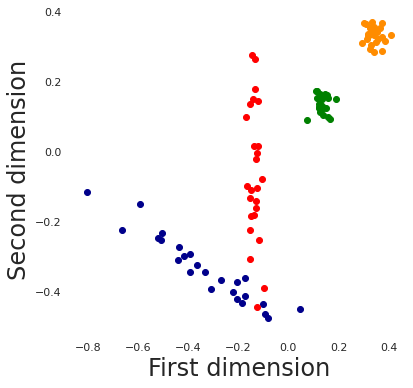

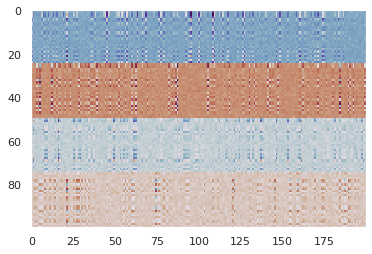

In [790]:
from pcmf import generate_cluster_PMD_data

# Data parameters
m = [25,25,25,25] # row 1,2
#m = [5,100] # row 3
n_X = 200 # row 1,2
#n_X = 2 # Fig 2
#sigma = 0.075 # Fig 1,2
sigma = 0.075 # Fig 2
density = 0.5
n_clusters = 4
seed = 7
means = [-1.0, 1.0, -0.4, 0.4]
np.random.seed(seed)

# Get clustered CCA data
X_clusters, u_true, v_true, _ = generate_cluster_PMD_data(m, n_X, sigma, density, n_clusters, means=means) # row 1,3
#X_clusters, u_true, v_true, _ = generate_cluster_PMD_data(m, n_X, sigma, density, n_clusters, means=[0,0]) # row 2

X_c = np.vstack(X_clusters)
true_clusters = np.repeat([0,1,2,3],m)

#scaler = StandardScaler()
#scaler.fit(X_c)
#X_c = scaler.transform(X_c)

plt.figure(figsize=(6,6))
plt.scatter(X_clusters[0][:,0],X_clusters[0][:,1], c='darkblue')
plt.scatter(X_clusters[1][:,0],X_clusters[1][:,1], c='darkorange' )
plt.scatter(X_clusters[2][:,0],X_clusters[2][:,1], c='red' )
plt.scatter(X_clusters[3][:,0],X_clusters[3][:,1], c='green' )

plt.xlabel('First dimension',fontsize=24)
plt.ylabel('Second dimension',fontsize=24)
#plt.scatter(X_clusters[2][:,0],X_clusters[2][:,1])
#plt.axis("off")

#X_c = np.hstack((X_c,np.ones((X_c.shape[0],1)))) # For rows 1,3


plt.figure()
maxval = np.max(np.abs(X_c))
plt.imshow(X_c,aspect='auto',interpolation='nearest',cmap='twilight_shifted',vmin=-1*maxval, vmax=maxval)  
#plt.axis('off')




In [667]:
# !! THIS IS IT !!
p=58
Vv=np.tile(results['V'][p],(X.shape[0],1))*np.sign(results['U'][p])
# Vv=np.tile(results['V'][p],(X.shape[0],1))

U_pcmf_cluster=np.zeros((X.shape[0],1))
V_pcmf_cluster=np.zeros((20,X.shape[1]))
S_pcmf_cluster=np.zeros((20,1))
U_SVD_cluster=np.zeros((X.shape[0],1))
V_SVD_cluster=np.zeros((20,X.shape[1]))
S_SVD_cluster=np.zeros((20,1))
for m in range(20):
    inds = true_clusters==m
    V_pcmf_cluster[m,:] = np.mean(Vv[inds,:])
#     Uu = (results['U'][p][inds])
    Uu = np.abs(results['U'][p][inds])
    U_pcmf_cluster[inds] = np.sqrt(1./np.sum(Uu**2))*Uu # Unit vector
    S_pcmf_cluster[m] = U_pcmf_cluster[inds].T@X[inds,:]@V_pcmf_cluster[m,:].T
    U, S, V = randomized_svd(X[inds,:], n_components=1,random_state=1234)
    U, S, V = randomized_svd(X[inds,:]-np.mean(X[inds,:],axis=0), n_components=1,random_state=1234)
    U_SVD_cluster[inds] = U
    S_SVD_cluster[m] = S
    V_SVD_cluster[m,:] = V
    
print(np.vstack((S_pcmf_cluster.T,S_SVD_cluster.T)))

# print(np.hstack((U_pcmf_cluster[inds],U_SVD_cluster[inds])))

print(np.hstack((V_pcmf_cluster[m,0:3],V_SVD_cluster[m,0:3])))

[[122.54990491 122.49107578 113.04272183 112.9853993   96.58200483
   96.53291597  87.29063292  87.0058813   73.04113425  73.08911489
   66.00440511  65.98860798  49.55259194  49.35096412  35.39270768
   35.37396969  23.75612387  23.52404747   9.37164063   9.45641539]
 [  5.91018446   6.86853917   4.84950252   5.68832338   4.67284658
    5.34725961   5.73487132   5.3723019    4.70773363   4.49895149
    4.29250855   5.13954757   6.17492288   5.36348948   4.75206404
    5.21377829   5.07132462   6.78485422   6.11728204   6.25378772]]
[ 0.09999959  0.09999959  0.09999959 -0.00452754  0.00660405  0.00171458]


In [670]:
# irisSvd2$v[1,1]*irisSvd2$d[1]/sqrt(nIris-1)*1.2,

x = V_SVD_cluster[m,0] * S_SVD_cluster[m] / math.sqrt(X[inds,:].shape[0]-1)*1.2
y = V_SVD_cluster[m,1] * S_SVD_cluster[m] / math.sqrt(X[inds,:].shape[0]-1)*1.2
print(x,y)

x = V_pcmf_cluster[m,0] * S_pcmf_cluster[m] / math.sqrt(X[inds,:].shape[0]-1)*1.2
y = V_pcmf_cluster[m,1] * S_pcmf_cluster[m] / math.sqrt(X[inds,:].shape[0]-1)*1.2
print(x,y)

[-0.00485387] [0.00708006]
[0.16210931] [0.16210931]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


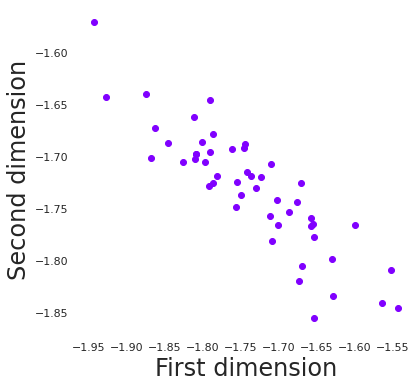

In [133]:
plt.figure(figsize=(6,6))
ax = plt.axes()
ax.set(facecolor = "white")
plt.xlabel('First dimension',fontsize=24)
plt.ylabel('Second dimension',fontsize=24)
colors = cm.rainbow(np.linspace(0, 1, 20))
i=0
plt.scatter(X[true_clusters==i,0],X[true_clusters==i,1], c=colors[i])


In [509]:
# import numpy
# import scipy
# import scipy.stats
# import matplotlib.pyplot as plt

# # generate two normally distributed 2d arrays
# x1=numpy.random.multivariate_normal((100,420),[[120,80],[80,80]],400)
# x2=numpy.random.multivariate_normal((140,340),[[90,-70],[-70,80]],400)

# # fit a KDE to the data
# pdf1=scipy.stats.kde.gaussian_kde(x1.T)
# pdf2=scipy.stats.kde.gaussian_kde(x2.T)

# # create a grid over which we can evaluate pdf
# q,w=numpy.meshgrid(range(50,200,10), range(300,500,10))
# r1=pdf1([q.flatten(),w.flatten()])
# r2=pdf2([q.flatten(),w.flatten()])

# # sample the pdf and find the value at the 95th percentile
# s1=scipy.stats.scoreatpercentile(pdf1(pdf1.resample(1000)), 5)
# s2=scipy.stats.scoreatpercentile(pdf2(pdf2.resample(1000)), 5)

# # reshape back to 2d
# r1.shape=(20,15)
# r2.shape=(20,15)

# # plot the contour at the 95th percentile
# plt.contour(range(50,200,10), range(300,500,10), r1, [s1],colors='b')
# plt.contour(range(50,200,10), range(300,500,10), r2, [s2],colors='r')

# # scatter plot the two normal distributions
# plt.scatter(x1[:,0],x1[:,1],alpha=0.3)
# plt.scatter(x2[:,0],x2[:,1],c='r',alpha=0.3)

# import numpy as np
# from scipy.stats import norm, chi2

# def cov_ellipse(cov, q=None, nsig=None, **kwargs):
#     """
#     Parameters
#     ----------
#     cov : (2, 2) array
#         Covariance matrix.
#     q : float, optional
#         Confidence level, should be in (0, 1)
#     nsig : int, optional
#         Confidence level in unit of standard deviations. 
#         E.g. 1 stands for 68.3% and 2 stands for 95.4%.

#     Returns
#     -------
#     width, height, rotation :
#          The lengths of two axises and the rotation angle in degree
#     for the ellipse.
#     """

#     if q is not None:
#         q = np.asarray(q)
#     elif nsig is not None:
#         q = 2 * norm.cdf(nsig) - 1
#     else:
#         raise ValueError('One of `q` and `nsig` should be specified.')
#     r2 = chi2.ppf(q, 2)

#     val, vec = np.linalg.eigh(cov)
#     width, height = 2 * sqrt(val[:, None] * r2)
#     rotation = np.degrees(arctan2(*vec[::-1, 0]))

#     return width, height, rotation

# # import numpy as np

# # import matplotlib.pyplot as plt
# # from matplotlib.patches import Ellipse

# # def plot_point_cov(points, nstd=2, ax=None, **kwargs):
# #     """
# #     Plots an `nstd` sigma ellipse based on the mean and covariance of a point
# #     "cloud" (points, an Nx2 array).
# #     Parameters
# #     ----------
# #         points : An Nx2 array of the data points.
# #         nstd : The radius of the ellipse in numbers of standard deviations.
# #             Defaults to 2 standard deviations.
# #         ax : The axis that the ellipse will be plotted on. Defaults to the 
# #             current axis.
# #         Additional keyword arguments are pass on to the ellipse patch.
# #     Returns
# #     -------
# #         A matplotlib ellipse artist
# #     """
# #     pos = points.mean(axis=0)
# #     cov = np.cov(points, rowvar=False)
# #     return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

# # def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
# #     """
# #     Plots an `nstd` sigma error ellipse based on the specified covariance
# #     matrix (`cov`). Additional keyword arguments are passed on to the 
# #     ellipse patch artist.
# #     Parameters
# #     ----------
# #         cov : The 2x2 covariance matrix to base the ellipse on
# #         pos : The location of the center of the ellipse. Expects a 2-element
# #             sequence of [x0, y0].
# #         nstd : The radius of the ellipse in numbers of standard deviations.
# #             Defaults to 2 standard deviations.
# #         ax : The axis that the ellipse will be plotted on. Defaults to the 
# #             current axis.
# #         Additional keyword arguments are pass on to the ellipse patch.
# #     Returns
# #     -------
# #         A matplotlib ellipse artist
# #     """
# #     def eigsorted(cov):
# #         vals, vecs = np.linalg.eigh(cov)
# #         order = vals.argsort()[::-1]
# #         return vals[order], vecs[:,order]

# #     if ax is None:
# #         ax = plt.gca()

# #     vals, vecs = eigsorted(cov)
# #     theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

# #     # Width and height are "full" widths, not radius
# #     width, height = 2 * nstd * np.sqrt(vals)
# #     ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

# #     ax.add_artist(ellip)
# #     return ellip

# # if __name__ == '__main__':
# #     #-- Example usage -----------------------
# #     # Generate some random, correlated data
# #     points = np.random.multivariate_normal(
# #             mean=(1,1), cov=[[0.4, 9],[9, 10]], size=1000
# #             )
# #     # Plot the raw points...
# #     x, y = points.T
# #     plt.plot(x, y, 'ro')

# #     # Plot a transparent 3 standard deviation covariance ellipse
# #     plot_point_cov(points, nstd=3, alpha=0.5, color='green')

# #     plt.show()
    


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

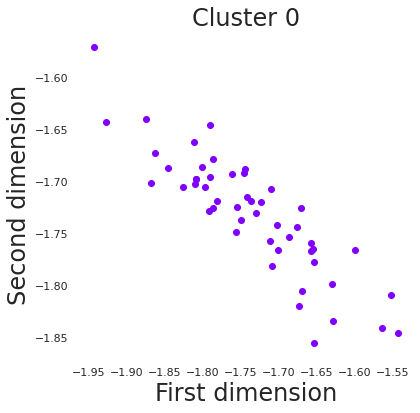

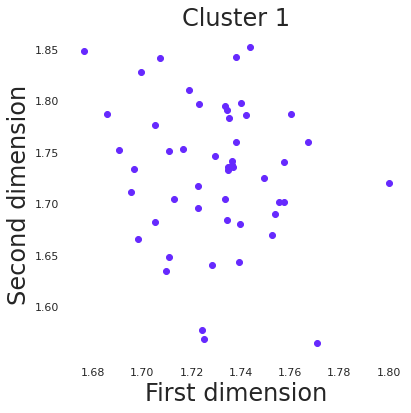

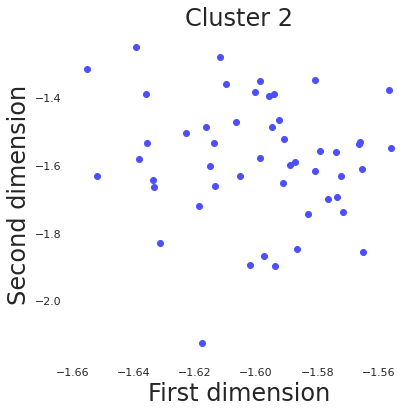

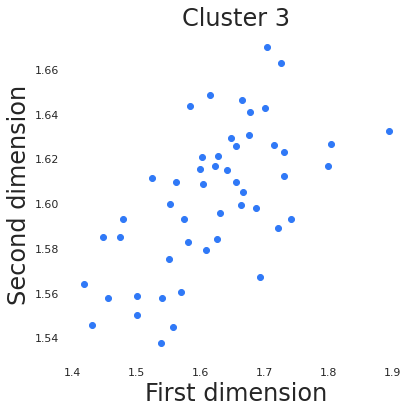

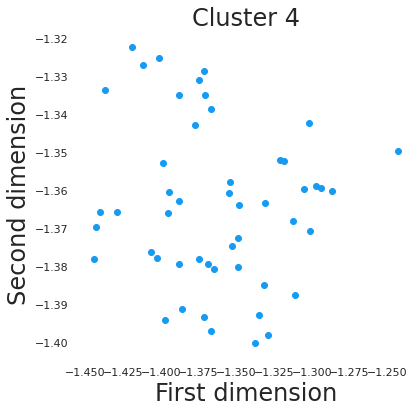

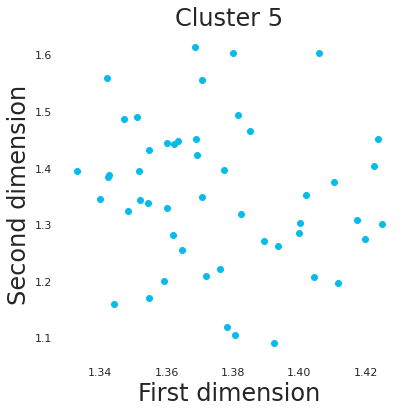

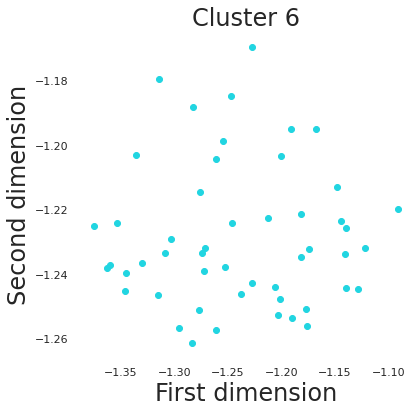

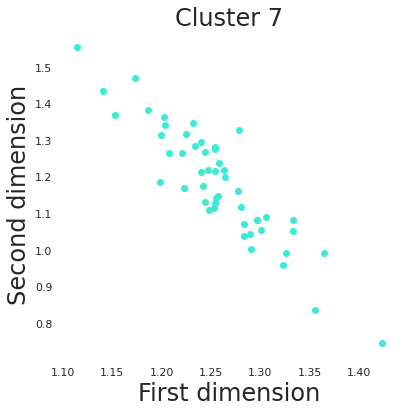

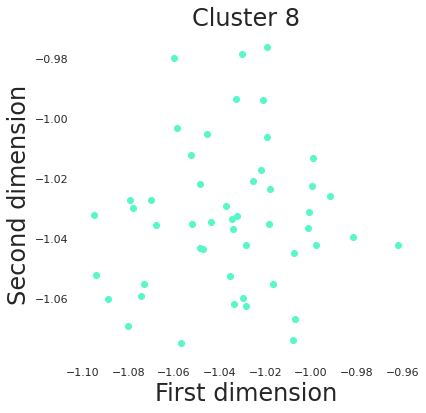

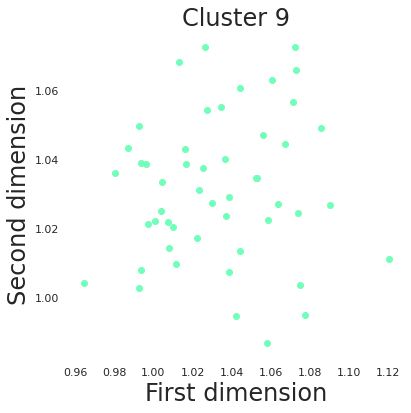

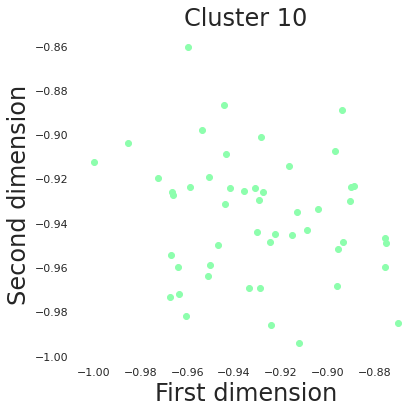

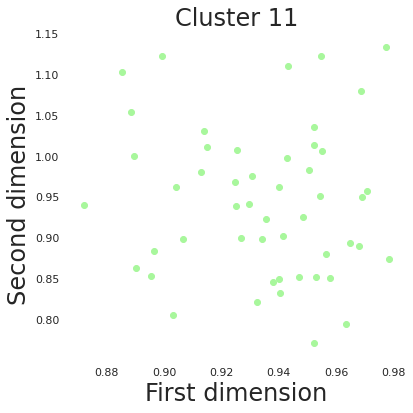

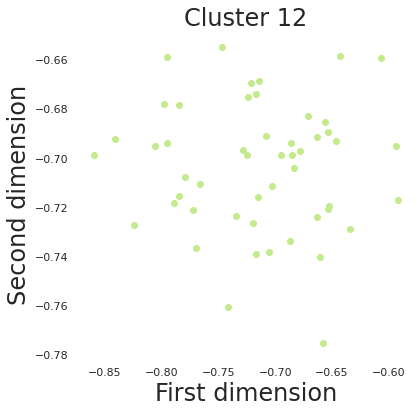

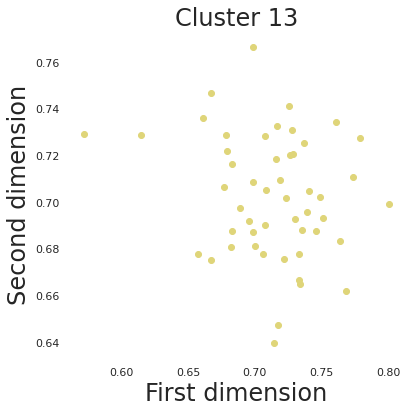

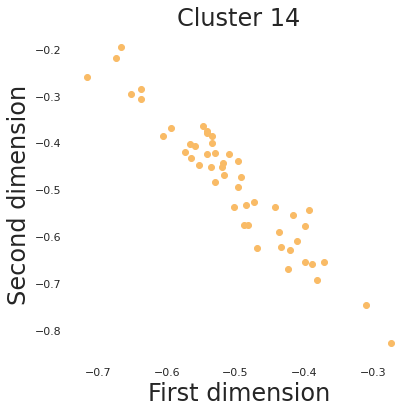

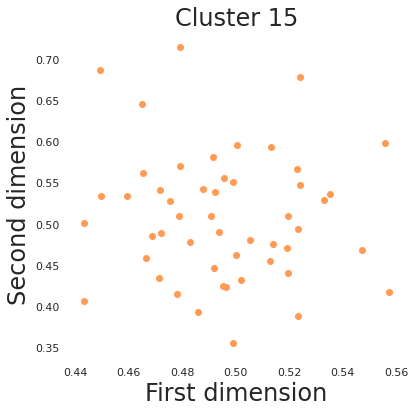

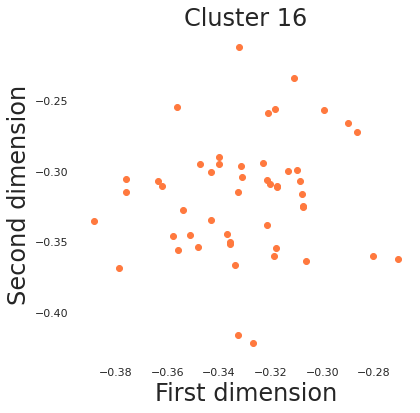

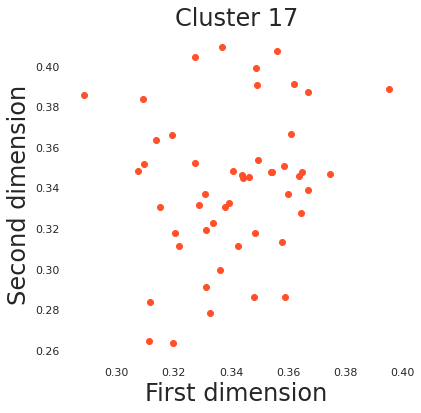

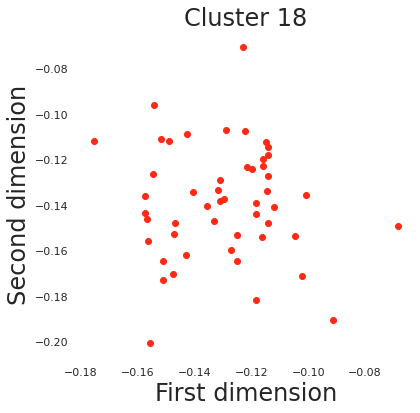

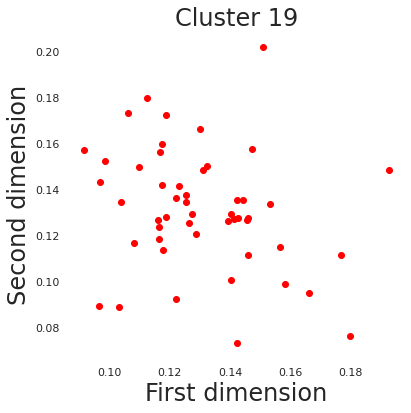

In [224]:
for i in range(20):
    plt.figure(figsize=(6,6))
    ax = plt.axes()
    ax.set(facecolor = "white")
    plt.xlabel('First dimension',fontsize=24)
    plt.ylabel('Second dimension',fontsize=24)
    plt.title('Cluster '+str(i),fontsize=24)
    colors = cm.rainbow(np.linspace(0, 1, 20))
    plt.scatter(X[true_clusters==i,0],X[true_clusters==i,1], c=colors[i])


In [661]:
# def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
#     """
#     Create a plot of the covariance confidence ellipse of `x` and `y`

#     Parameters
#     ----------
#     x, y : array_like, shape (n, )
#         Input data.

#     ax : matplotlib.axes.Axes
#         The axes object to draw the ellipse into.

#     n_std : float
#         The number of standard deviations to determine the ellipse's radiuses.

#     Returns
#     -------
#     matplotlib.patches.Ellipse

#     Other parameters
#     ----------------
#     kwargs : `~matplotlib.patches.Patch` properties
#     """
#     if x.size != y.size:
#         raise ValueError("x and y must be the same size")

#     cov = np.cov(x, y)
#     pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
#     # Using a special case to obtain the eigenvalues of this
#     # two-dimensionl dataset.
#     ell_radius_x = np.sqrt(1 + pearson)
#     ell_radius_y = np.sqrt(1 - pearson)
#     ellipse = Ellipse((0, 0),
#                       width=ell_radius_x * 2,
#                       height=ell_radius_y * 2,
#                       facecolor=facecolor,
#                       **kwargs)

#     # Calculating the stdandard deviation of x from
#     # the squareroot of the variance and multiplying
#     # with the given number of standard deviations.
#     scale_x = np.sqrt(cov[0, 0]) * n_std
#     mean_x = np.mean(x)

#     # calculating the stdandard deviation of y ...
#     scale_y = np.sqrt(cov[1, 1]) * n_std
#     mean_y = np.mean(y)

#     transf = transforms.Affine2D() \
#         .rotate_deg(45) \
#         .scale(scale_x, scale_y) \
#         .translate(mean_x, mean_y)

#     ellipse.set_transform(transf + ax.transData)
    
#     return ax.add_patch(ellipse)

# from matplotlib import pyplot
# # method = PCA(n_components=2, whiten=True)  # project to 2 dimensions
# # projected = method.fit_transform(np.array(inputs[tags['datum']].tolist()))
# projected = X[:,0:2]

# # plt.figure(figsize=(6,6))
# # ax = plt.axes()
# # ax.set(facecolor = "white")

# figure = pyplot.figure()
# axis = figure.add_subplot(111)
# colors = cm.rainbow(np.linspace(0, 1, 20))
# # 
# # Display data
# plt.style.use('fast')
# for i in range(1):
# #     color = np.expand_dims(np.array(settings.get_color(label)), axis=0)
#     inds = true_clusters==i
#     plt.scatter(projected[inds, 0], projected[inds, 1],
#                            c=colors[i], alpha=0.5, edgecolor='none')


# import numpy as np

# import matplotlib.pyplot as plt
# from matplotlib.patches import Ellipse, transforms

# # see https://statomics.github.io/HDA2020/svd.html
# # Centroids
# for m in range(1):
#     # Ellipsis
    
#     inds = true_clusters==m
#     confidence_ellipse(projected[inds, 0], projected[inds, 1], axis,
#                              edgecolor=colors[i], linewidth=3, zorder=0)
#     confidence_ellipse(projected[inds, 0], projected[inds, 1], axis,
#                              edgecolor=colors[i], linewidth=3, zorder=0, n_std=1)
# #     plt.arrow(-1.8,-1.8,0.1,0.2,facecolor='black',edgecolor='black',linewidth=2, label='e1',head_width=0.01,head_length=0.01)
    
#     x = int(V_SVD_cluster[m,0] * S_SVD_cluster[m] / math.sqrt(X[inds,:].shape[0]-1)) #*1.2)
#     y = int(V_SVD_cluster[m,1] * S_SVD_cluster[m]/ math.sqrt(X[inds,:].shape[0]-1)) #*1.2)
#     print(x,y)
#     mean_X = np.mean(projected[inds, 0])
#     mean_Y = np.mean(projected[inds, 1])
#     plt.arrow(mean_X,mean_Y,-0.3,0.3,facecolor='black',edgecolor='black',linewidth=2, label='e1',head_width=0.01,head_length=0.01)

#     x = V_pcmf_cluster[m,0] * S_pcmf_cluster[m] / math.sqrt(X[inds,:].shape[0]-1)*1.2
#     y = V_pcmf_cluster[m,1] * S_pcmf_cluster[m] / math.sqrt(X[inds,:].shape[0]-1)*1.2
#     print(x,y)


# # # The confidence_ellipse came from matplotlib example.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.0 0.0


-1.2878587085651815e-16

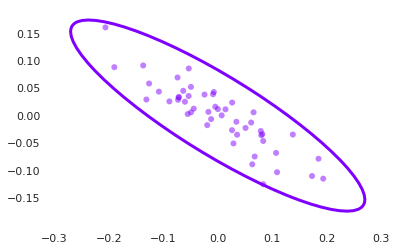

In [668]:
import matplotlib
matplotlib.rcParams.update({"axes.grid" : False, "axes.facecolor" : 'white'})
figure = pyplot.figure()
axis = figure.add_subplot(111)
colors = cm.rainbow(np.linspace(0, 1, 20))

i=0
# Ellipsis
inds = true_clusters==i
projected = X[inds,:]-np.mean(X[inds,:],axis=0) #*S_SVD_cluster[i]*V_SVD_cluster[i,0]
mean_X = np.mean(projected[:, 0])
mean_Y = np.mean(projected[:, 1])
# projected = 
plt.scatter(projected[:, 0], projected[:, 1],
                       c=colors[i], alpha=0.5, edgecolor='none')
confidence_ellipse(projected[:, 0], projected[:, 1], axis,
                         edgecolor=colors[i], linewidth=3, zorder=0)
# confidence_ellipse(projected[inds, 0], projected[inds, 1], axis,
#                          edgecolor=colors[i], linewidth=3, zorder=0, n_std=1)
# plt.scatter(projected[inds, 0], projected[inds, 1],
#                        c=colors[i], alpha=0.5, edgecolor='none')
# confidence_ellipse(projected[inds, 0], projected[inds, 1], axis,
#                          edgecolor=colors[i], linewidth=3, zorder=0)
# confidence_ellipse(projected[inds, 0], projected[inds, 1], axis,
#                          edgecolor=colors[i], linewidth=3, zorder=0, n_std=1)
#     plt.arrow(-1.8,-1.8,0.1,0.2,facecolor='black',edgecolor='black',linewidth=2, label='e1',head_width=0.01,head_length=0.01)

x = int(V_SVD_cluster[i,0] * S_SVD_cluster[i] / math.sqrt(X[inds,:].shape[0]-1))*1.2
y = int(V_SVD_cluster[i,1] * S_SVD_cluster[i] / math.sqrt(X[inds,:].shape[0]-1))*1.2
print(x,y)
plt.plot((x,0),(y,0))
mean_X
# mean_X = np.mean(projected[inds, 0])
# mean_Y = np.mean(projected[inds, 1])
# print(mean_X,mean_Y)
# plt.arrow(mean_X,mean_Y,1,-1,facecolor='black',edgecolor='black',linewidth=2, label='e1',head_width=0.01,head_length=0.01)

# x = int(V_pcmf_cluster[i,0] * S_pcmf_cluster[i] / math.sqrt(X[inds,:].shape[0]-1)*1.2)
# y = int(V_pcmf_cluster[i,1] * S_pcmf_cluster[i] / math.sqrt(X[inds,:].shape[0]-1)*1.2)
# plt.arrow(mean_X,mean_Y,-.2,.2,facecolor='black',edgecolor='black',linewidth=2, label='e1',head_width=0.01,head_length=0.01)
# print(x,y)
